# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import Image

from matplotlib import pyplot as plt
from IPython.core.display import HTML
from sklearn import model_selection as ms


from sklearn.metrics import recall_score, precision_score,f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold


from lightgbm                import LGBMClassifier
# from xgboost import XGBClassifier

from sklearn.neighbors       import KNeighborsClassifier
from sklearn.naive_bayes     import GaussianNB
from sklearn.linear_model    import LogisticRegression
from sklearn.ensemble        import RandomForestClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix
from xgboost                 import XGBClassifier 
from sklearn_evaluation import plot


from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

# from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score # AUC PRC

from numpy import set_printoptions
set_printoptions(suppress = True)

# 0.1 Auxiliar Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display(HTML ('<style>.container {width:100% !important;} </style>') )
    pd.options.display.max_columns=None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr',False)
    pd.set_option('display.float_format', lambda x: '%.4f' % x)
    
    sns.set()
    
jupyter_settings()

def feature_importance(model,x_train_n,y_train_n):
    
    # Model Training
    model.fit(x_train_n,y_train_n)
    
    # Importance
    importances = model.feature_importances_

    # Std
    std = np.std([tree.feature_importances_ for tree in model.estimators_],axis=0)

    # Indice
    indices = np.argsort(importances)[::-1]

    # Print Feature Ranking
    print('Feature Ranking')
    df = pd.DataFrame()

    for i, j in zip(x_train_n,model.feature_importances_):
        aux = pd.DataFrame({'feature': i,'importance':j}, index=[0])
        df = pd.concat([df,aux],axis=0)

    #print(df.sort_values('importance',ascending=False))

    value = x_train_n.shape[1]
    
    return df.sort_values('importance',ascending=False)

    # plt.figure()
    # plt.title('Feature Importances')
    # plt.bar(range(value),importances[indices] ,color='r',yerr=std[indices],align='center')
    # plt.xticks(range(value),indices)
    # plt.xlim([-1,value])
    # plt.show()

def cross_validation(model, x_train, y_train, k, Verbose=True):
    
    kfold = StratifiedKFold(n_splits=k,shuffle=True,random_state=42)
    
    recall_list = []
    f1_score_list = []
    roc_auc_list = []
    prc_auc_list = []
    i = 1
    
    for train_cv, val_cv in kfold.split(x_train,y_train):
        
        if Verbose == True:
            print(f'Fold Number {i}/{k}')
            
        else:
            pass
        
        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]
        
        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]
        
        model.fit(x_train_fold,y_train_fold)
        
        yhat_model = model.predict(x_val_fold)
        yhat_model_proba = model.predict_proba(x_val_fold)
        
        

        # Metrics 
        
        # Recall 
        recall = recall_score(y_val_fold, yhat_model)
        recall_list.append(recall)
        
        # F1 Score
        f1score = f1_score(y_val_fold,yhat_model)
        f1_score_list.append(f1score)
        
        # ROC AUC
        roc_auc = roc_auc_score(y_val_fold,yhat_model_proba[:,1])
        roc_auc_list.append(roc_auc)
        
        # PRC AUC
        prc_auc = average_precision_score(y_val_fold,yhat_model_proba[:,1])
        prc_auc_list.append(prc_auc)
        
        i+=1
        
    
    df = pd.DataFrame( {'Model Name': type(model).__name__,
                        'Recall': np.mean(recall_list),
                        'F1 Score': np.mean(f1_score_list),
                        'PRC AUC': np.mean(prc_auc_list),
                        'ROC AUC': np.mean(roc_auc_list)},index=[0])
    
    return df


def classification_metrics(model,x_validation, y_validation):
        
    yhat = model.predict(x_validation)
    yhat_proba = model.predict_proba(x_validation)
        
    
    # Metrics 
    recall = recall_score(y_validation,yhat)
    
    # F1_Score
    f1score = f1_score(y_validation,yhat)
    
    # AUC SCORE
    roc_auc = roc_auc_score(y_validation, yhat_proba[:,1])
    
    # PRC AUC
    prc_auc = average_precision_score(y_validation, yhat_proba[:,1])
    
    # PLOT PRC 
    prec, recall_, _ = precision_recall_curve(y_validation, yhat, pos_label=model.classes_[1])
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall_).plot()
    
    cm = confusion_matrix(y_validation, yhat, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
    disp.plot()
    
    return pd.DataFrame({'Model_Name':type(model).__name__,
                         'Recall':recall,
                         'F1_Score':f1score,
                         'PRC AUC': prc_auc,
                         'AUC SCORE':roc_auc},index=[0])


    

# 0.2 Loading Data

In [3]:
# Analysing Data
df_raw_prev = pd.read_csv('../data/air_system_previous_years.csv')
df_raw_present =  pd.read_csv('../data/air_system_present_year.csv')

# 1.0 Data Description

In [4]:
df1 = df_raw_prev.copy()
df1_test = df_raw_present.copy()

## 1.1 Data Columns

In [5]:
df1.columns

Index(['class', 'aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000',
       'ag_000', 'ag_001', 'ag_002',
       ...
       'ee_002', 'ee_003', 'ee_004', 'ee_005', 'ee_006', 'ee_007', 'ee_008',
       'ee_009', 'ef_000', 'eg_000'],
      dtype='object', length=171)

In [6]:
df1_test.columns

Index(['class', 'aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000',
       'ag_000', 'ag_001', 'ag_002',
       ...
       'ee_002', 'ee_003', 'ee_004', 'ee_005', 'ee_006', 'ee_007', 'ee_008',
       'ee_009', 'ef_000', 'eg_000'],
      dtype='object', length=171)

## 1.2 Data Dimension 


In [7]:
print('Formato do dataset: {} linhas e {} colunas'.format(df1.shape[0], df1.shape[1]))
print('Formato do dataset de teste: {} linhas e {} colunas'.format(df1_test.shape[0], df1_test.shape[1]))

Formato do dataset: 60000 linhas e 171 colunas
Formato do dataset de teste: 16000 linhas e 171 colunas


## 1.3 Data Types

In [8]:
# df1.dtypes

Nessa etapa podemos observar que praticamente todas variáveis estão como tipo de objeto (menos a 1º) , portanto precisamos transformas elas em um tipo númerico visto que só possuímos numeros como valores.

## 1.4 Check NA / Check Duplicated Rows

In [9]:
df1 = df1.replace('na',np.nan)
df1_test = df1_test.replace('na',np.nan)

In [10]:
# Transform object features as float
df1 = df1.astype({col: float for col in df1.columns[1:]})
df1_test = df1_test.astype({col: float for col in df1_test.columns[1:]})

In [11]:
# df1.isna().sum()
# df1_test.isna().sum()

In [12]:
# CHECK DUPLICATED ROWS ON TRAIN
duplicated_train = df1[df1.duplicated()]
duplicated_train


,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000


In [13]:
# CHECK DUPLICATED ROWS ON TEST
duplicated_test = df1_test[df1_test.duplicated()]
duplicated_test

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000


## 1.5 Checking Duplicated Features

In [14]:
#Check duplicated rows in train
feature_duplicated_train = df1.T.drop_duplicates().T

#Check duplicated columns in test
feature_duplicated_teste = df1_test.T.drop_duplicates().T

In [15]:
print(df1.shape,feature_duplicated_train.shape)

(60000, 171) (60000, 171)


In [16]:
print(df1_test.shape,feature_duplicated_teste.shape)

(16000, 171) (16000, 171)


## 1.6 Replace / Fill NA

In [17]:
df1 = df1.replace(np.nan,0)
df1_test = df1_test.replace(np.nan,0)

## 1.7 Descriptive Statistics

In [18]:
num_attributes = df1.select_dtypes(include=['float64'])

In [19]:
num_attributes.head()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,76698.0000,0.0000,2130706438.0000,280.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,37250.0000,1432864.0000,3664156.0000,1007684.0000,25896.0000,0.0000,2551696.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4933296.0000,3655166.0000,1766008.0000,1132040.0000,0.0000,0.0000,0.0000,0.0000,1012.0000,268.0000,0.0000,0.0000,0.0000,0.0000,0.0000,469014.0000,4239660.0000,703300.0000,755876.0000,0.0000,5374.0000,2108.0000,4114.0000,12348.0000,615248.0000,5526276.0000,2378.0000,4.0000,0.0000,0.0000,2328746.0000,1022304.0000,415432.0000,287230.0000,310246.0000,681504.0000,1118814.0000,3574.0000,0.0000,0.0000,6700214.0000,0.0000,10.0000,108.0000,50.0000,2551696.0000,97518.0000,947550.0000,799478.0000,330760.0000,353400.0000,299160.0000,305200.0000,283680.0000,0.0000,0.0000,0.0000,178540.0000,76698.0800,6700214.0000,6700214.0000,6599892.0000,43566.0000,68656.0000,54064.0000,638360.0000,6167850.0000,1209600.0000,246244.0000,2.0000,96.0000,0.0000,5245752.0000,0.0000,916567.6800,6.0000,1924.0000,0.0000,0.0000,0.0000,118196.0000,1309472.0000,3247182.0000,1381362.0000,98822.0000,11208.0000,1608.0000,220.0000,240.0000,6700214.0000,0.0000,10476.0000,1226.0000,267998.0000,521832.0000,428776.0000,4015854.0000,895240.0000,26330.0000,118.0000,0.0000,532.0000,734.0000,4122704.0000,51288.0000,0.0000,532572.0000,0.0000,18.0000,5330690.0000,4732.0000,1126.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,62282.0000,85908.0000,32790.0000,0.0000,0.0000,202710.0000,37928.0000,14745580.0000,1876644.0000,0.0000,0.0000,0.0000,0.0000,2801180.0000,2445.8000,2712.0000,965866.0000,1706908.0000,1240520.0000,493384.0000,721044.0000,469792.0000,339156.0000,157956.0000,73224.0000,0.0000,0.0000,0.0000
1,33058.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,18254.0000,653294.0000,1720800.0000,516724.0000,31642.0000,0.0000,1393352.0000,0.0000,68.0000,0.0000,0.0000,0.0000,2560898.0000,2127150.0000,1084598.0000,338544.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,71510.0000,772720.0000,1996924.0000,99560.0000,0.0000,7336.0000,7808.0000,13776.0000,13086.0000,1010074.0000,1873902.0000,14726.0000,6.0000,0.0000,0.0000,1378576.0000,447166.0000,199512.0000,154298.0000,137280.0000,138668.0000,165908.0000,229652.0000,87082.0000,4708.0000,3646660.0000,86.0000,454.0000,364.0000,350.0000,1393352.0000,49028.0000,688314.0000,392208.0000,341420.0000,359780.0000,366560.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6700.0000,33057.5100,3646660.0000,3646660.0000,3582034.0000,17733.0000,260120.0000,115626.0000,6900.0000,2942850.0000,1209600.0000,0.0000,0.0000,0.0000,0.0000,2291079.3600,0.0000,643536.9600,0.0000,0.0000,0.0000,0.0000,38.0000,98644.0000,1179502.0000,1286736.0000,336388.0000,36294.0000,5192.0000,56.0000,0.0000,0.0000,3646660.0000,0.0000,6160.0000,796.0000,1

In [20]:
num_attributes.describe()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000
mean,59336.4996,0.1625,336225803.5780,143407.0840,6.5350,10.5482,219.1577,964.8104,8509.7706,87600.5353,432208.4350,1095978.5163,1639277.9562,493725.8562,35172.1011,5057.5532,1790474.4160,8922.4376,1131.6853,907.6607,58497.7795,92303.4325,3424003.9471,2972966.3513,993415.0497,438061.5272,0.4744,125.4079,5018.8743,228.1631,1071.2498,358.7242,12075.0811,10076.1593,10852.2609,7144.9755,10447.8373,110726.8142,1066489.4016,1528742.5661,1039367.9056,1149.6196,7761.8229,4371.5509,7975.8758,86265.1756,1460380.0346,2111700.9117,100754.7404,17183.4753,654.3852,41.6029,1383602.6142,883864.9220,408360.0872,270865.0115,202526.3397,186774.6638,208213.6121,183657.0236,35471.3825,35356.5960,4477520.7830,543.6606,879.8808,1315.3839,71.7583,1790070.0730,57323.0912,487375.7352,505081.8546,172772.3773,175260.9450,136204.7397,123586.6657,116886.5210,112667.3157,109560.3797,108234.3780,79388.1867,59251.1285,4463323.2152,4463323.7916,3888993.191

In [21]:
# Central Tendency - Media, Mediana 
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion std, min, max, range,skew,kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

In [22]:
# Concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns=['attributes','min','max','range','mean','median','std','skew','kurtosis']

In [23]:
m.head()

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,aa_000,0.0000,2746564.0000,2746564.0000,59336.4996,30776.0000,145428.8446,6.1158,48.2974
1,ab_000,0.0000,204.0000,204.0000,0.1625,0.0000,1.6873,57.0362,5119.1661
2,ac_000,0.0000,2130706796.0000,2130706796.0000,336225803.5780,120.0000,776756070.8145,1.8774,1.5247
3,ad_000,0.0000,8584297742.0000,8584297742.0000,143407.0840,42.0000,35044955.4882,244.9490,59999.9992
4,ae_000,0.0000,21050.0000,21050.0000,6.5350,0.0000,158.1466,92.5316,11228.4059


# 4.0 EDA

In [24]:
df4 = df1.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

In [25]:
df4['class'] = df4['class'].apply(lambda x: 1 if x == 'pos' else 0)

- 59000 caminhões com outros tipos de manutenção. (98%)
- 1000 caminhões com manutenção de sistema de ar. (2%)

# 5.0 Data Preparation

In [26]:
df5 = df4.copy()

In [27]:
X = df4.drop('class',axis=1)
y = df4['class'].copy()

In [28]:
x_train, x_validation, y_train, y_validation = ms.train_test_split(X,y,test_size=0.20,random_state=42)

In [29]:
x_train.head()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
48572,18.0000,0.0000,22.0000,20.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,10.0000,1916.0000,2956.0000,0.0000,0.0000,0.0000,606.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6408.0000,4912.0000,31398.0000,492.0000,0.0000,0.0000,0.0000,0.0000,10.0000,22.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,960.0000,3922.0000,0.0000,98.0000,58.0000,84.0000,1010.0000,128.0000,3504.0000,0.0000,0.0000,0.0000,0.0000,3344.0000,416.0000,156.0000,94.0000,180.0000,108.0000,444.0000,62.0000,10.0000,68.0000,37822.0000,0.0000,6.0000,0.0000,0.0000,606.0000,126.0000,29982.0000,1396.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,31280.0000,17.9600,37822.0000,37822.0000,39494.0000,23.0000,10.0000,3732.0000,37700.0000,4934.0000,1209600.0000,322.0000,2.0000,0.0000,0.0000,2637.1200,286.0800,995.5200,2.0000,22.0000,0.0000,0.0000,0.0000,1272.0000,2714.0000,890.0000,6.0000,0.0000,0.0000,0.0000,0.0000,22.0000,37822.0000,0.0000,1030.0000,12.0000,18.0000,16.0000,346.0000,916.0000,2078.0000,448.0000,18.0000,0.0000,6.0000,28.0000,2530.0000,104.0000,0.0000,0.0000,0.0000,0.0000,2854.0000,32.0000,96.0000,0.0000,0.0000,280.0000,1666.0000,0.0000,0.0000,0.0000,0.0000,176.0000,0.0000,0.0000,0.0000,0.0000,62.0000,18.0000,10260.0000,1036.0000,0.0000,20.0000,0.0000,0.0000,0.0000,0.7600,44.0000,2434.0000,1962.0000,126.0000,64.0000,104.0000,154.0000,38.0000,0.0000,0.0000,0.0000,0.0000,0.0000
38696,30.0000,0.0000,42.0000,42.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,50.0000,4250.0000,3442.0000,0.0000,0.0000,0.0000,3058.0000,0.0000,0.0000,0.0000,0.0000,0.0000,7478.0000,5016.0000,12224.0000,1182.0000,0.0000,0.0000,0.0000,0.0000,108.0000,30.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,7742.0000,0.0000,0.0000,0.0000,52.0000,6.0000,10.0000,20.0000,180.0000,7432.0000,42.0000,0.0000,0.0000,0.0000,6030.0000,1288.0000,274.0000,66.0000,32.0000,18.0000,16.0000,18.0000,0.0000,0.0000,19714.0000,4.0000,20.0000,6.0000,0.0000,3058.0000,200.0000,9554.0000,2664.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,12100.0000,29.5100,19714.0000,19714.0000,25582.0000,17.0000,0.0000,1882.0000,19620.0000,7742.0000,1209600.0000,618.0000,0.0000,2.0000,0.0000,4595.5200,0.0000,3117.1200,0.0000,0.0000,0.0000,0.0000,0.0000,3722.0000,3834.0000,186.0000,0.0000,0.0000,0.0000,0.0000,6.0000,36.0000,19714.0000,0.0000,68.0000,10.0000,12.0000,268.0000,506.0000,1156.0000,4324.0000,1350.0000,48.0000,0.0000,72.0000,78.0000,5032.0000,66.0000,0.0000,28.0000,0.0000,0.0000,5124.0000,56.0000,40.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,120.0000,0.0000,0.0000,0.0000,0.0000,254.0000,50.0000,520.0000,58.0000,20522.0000,32.0000,0.0000,0.0000,0.0000,43.3200,28.0000,3470.0000,3348.0000,734.0000,82.0000,102.0000,6.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
13611,14.0000,0.0000,8.0000,0.0000,0.0000,0.0000,

## 5.1 Data Resampling -> UNDERSAMPLING

In [30]:
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import NeighbourhoodCleaningRule

### 5.1.3 NeighbourhoodCleaning Rule ( Condensed Nearest Neighbours + Edited Nearest Neighbors)

In [31]:
undersample = NeighbourhoodCleaningRule(n_neighbors=3, threshold_cleaning=0.5)
x_train ,y_train = undersample.fit_resample(x_train,y_train)


## 5.2 Rescaling Features

In [32]:
from sklearn import preprocessing as pp

In [33]:
x_train.head()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,18.0000,0.0000,22.0000,20.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,10.0000,1916.0000,2956.0000,0.0000,0.0000,0.0000,606.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6408.0000,4912.0000,31398.0000,492.0000,0.0000,0.0000,0.0000,0.0000,10.0000,22.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,960.0000,3922.0000,0.0000,98.0000,58.0000,84.0000,1010.0000,128.0000,3504.0000,0.0000,0.0000,0.0000,0.0000,3344.0000,416.0000,156.0000,94.0000,180.0000,108.0000,444.0000,62.0000,10.0000,68.0000,37822.0000,0.0000,6.0000,0.0000,0.0000,606.0000,126.0000,29982.0000,1396.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,31280.0000,17.9600,37822.0000,37822.0000,39494.0000,23.0000,10.0000,3732.0000,37700.0000,4934.0000,1209600.0000,322.0000,2.0000,0.0000,0.0000,2637.1200,286.0800,995.5200,2.0000,22.0000,0.0000,0.0000,0.0000,1272.0000,2714.0000,890.0000,6.0000,0.0000,0.0000,0.0000,0.0000,22.0000,37822.0000,0.0000,1030.0000,12.0000,18.0000,16.0000,346.0000,916.0000,2078.0000,448.0000,18.0000,0.0000,6.0000,28.0000,2530.0000,104.0000,0.0000,0.0000,0.0000,0.0000,2854.0000,32.0000,96.0000,0.0000,0.0000,280.0000,1666.0000,0.0000,0.0000,0.0000,0.0000,176.0000,0.0000,0.0000,0.0000,0.0000,62.0000,18.0000,10260.0000,1036.0000,0.0000,20.0000,0.0000,0.0000,0.0000,0.7600,44.0000,2434.0000,1962.0000,126.0000,64.0000,104.0000,154.0000,38.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,30.0000,0.0000,42.0000,42.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,50.0000,4250.0000,3442.0000,0.0000,0.0000,0.0000,3058.0000,0.0000,0.0000,0.0000,0.0000,0.0000,7478.0000,5016.0000,12224.0000,1182.0000,0.0000,0.0000,0.0000,0.0000,108.0000,30.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,7742.0000,0.0000,0.0000,0.0000,52.0000,6.0000,10.0000,20.0000,180.0000,7432.0000,42.0000,0.0000,0.0000,0.0000,6030.0000,1288.0000,274.0000,66.0000,32.0000,18.0000,16.0000,18.0000,0.0000,0.0000,19714.0000,4.0000,20.0000,6.0000,0.0000,3058.0000,200.0000,9554.0000,2664.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,12100.0000,29.5100,19714.0000,19714.0000,25582.0000,17.0000,0.0000,1882.0000,19620.0000,7742.0000,1209600.0000,618.0000,0.0000,2.0000,0.0000,4595.5200,0.0000,3117.1200,0.0000,0.0000,0.0000,0.0000,0.0000,3722.0000,3834.0000,186.0000,0.0000,0.0000,0.0000,0.0000,6.0000,36.0000,19714.0000,0.0000,68.0000,10.0000,12.0000,268.0000,506.0000,1156.0000,4324.0000,1350.0000,48.0000,0.0000,72.0000,78.0000,5032.0000,66.0000,0.0000,28.0000,0.0000,0.0000,5124.0000,56.0000,40.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,120.0000,0.0000,0.0000,0.0000,0.0000,254.0000,50.0000,520.0000,58.0000,20522.0000,32.0000,0.0000,0.0000,0.0000,43.3200,28.0000,3470.0000,3348.0000,734.0000,82.0000,102.0000,6.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,14.0000,0.0000,8.0000,0.0000,0.0000,0.0000,0.0000,0.000

In [34]:
sc = pp.StandardScaler()

x_train_scaler = sc.fit_transform(x_train)
# pickle.dump(sc,open('../features/standard_scaler_train.pkl','wb'))

x_val_scaler = sc.transform(x_validation)


# # #WITH COLUMNS NAMES
x_train = pd.DataFrame(x_train_scaler,columns=x_train.columns)
x_validation = pd.DataFrame(x_val_scaler,columns=x_validation.columns)

# 6.0 Feature Selection 

In [36]:
df6 = df5.drop(columns=['class'],axis=1)
df6_class = df5['class'].copy()

x_train_n = x_train.copy()
y_train_n = y_train.values

## 6.1.1 XGBoost Feature Selection

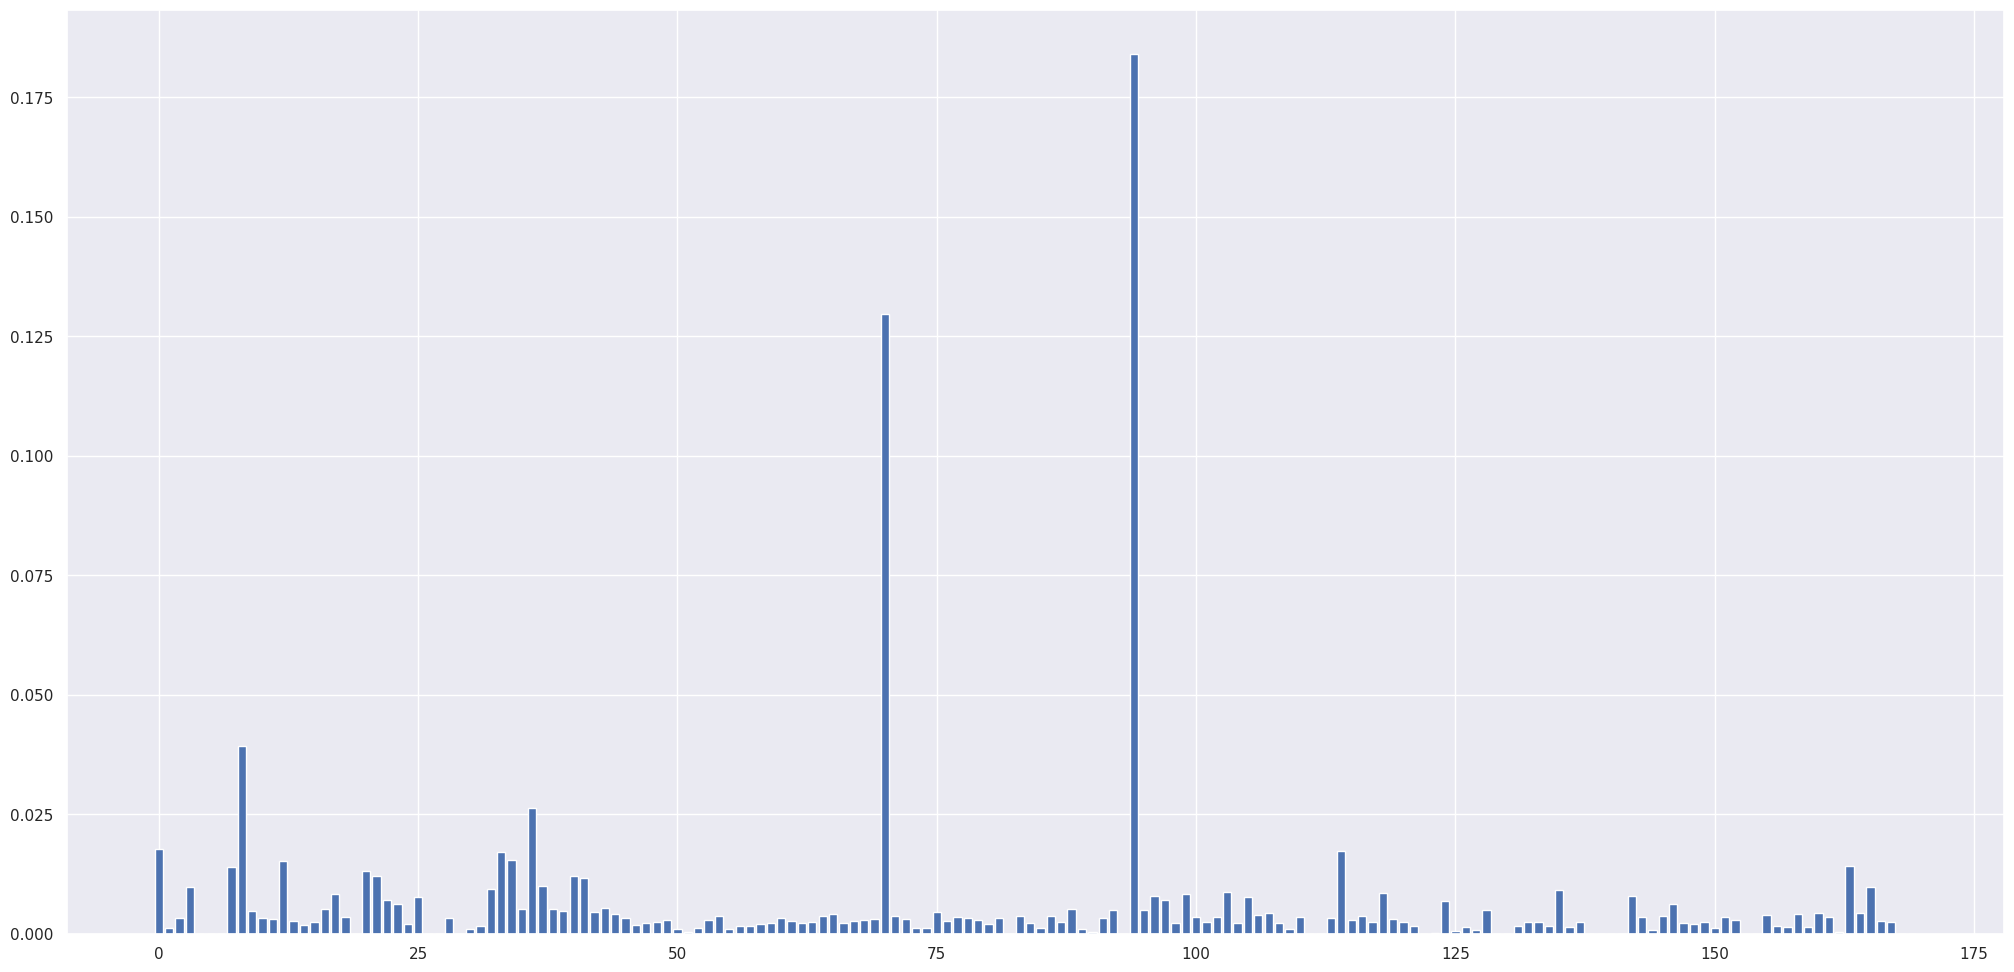

In [37]:
xgb = XGBClassifier(n_jobs=-1,random_state=42)
xgb.fit(x_train_n,y_train_n)

# x = ['importance']
xgb_features = pd.DataFrame(xgb.feature_importances_,)
xgb_features.columns = ['importance']


plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
plt.show()


In [38]:
xgb_features_final = xgb_features[xgb_features['importance'] >= 0.0050].sort_values('importance',ascending=False)
cols_selected_xgb = xgb_features_final.index

In [39]:
cols_selected_xgb.size

39

In [40]:
cols_selected_xgb

Int64Index([ 94,  70,   8,  36,   0, 114,  33,  34,  12, 163,   7,  20,  21,
             40,  41,  37, 165,   3,  32, 135, 103, 118,  99,  17, 142,  96,
            105,  25,  22,  97, 124, 146,  23,  43,  38,  88,  16,  35,  95],
           dtype='int64')

In [41]:
cols_selected = df6.iloc[:,[ 94,  70,   8,  36,   0, 114,  33,  34,  12, 163,   7,  20,  21,
             40,  41,  37, 165,   3,  32, 135, 103, 118,  99,  17, 142,  96,
            105,  25,  22,  97, 124, 146,  23,  43,  38,  88,  16,  35,  95]].columns

## 6.1.2 Features Final Selection

In [42]:
x_train = x_train[cols_selected]
x_validation = x_validation[cols_selected]

# 7.0 Machine Learning Model

## 7.1 KNN Base Model 

,Model_Name,Recall,F1_Score,PRC AUC,AUC SCORE
0,KNeighborsClassifier,0.7123,0.6959,0.6696,0.9486


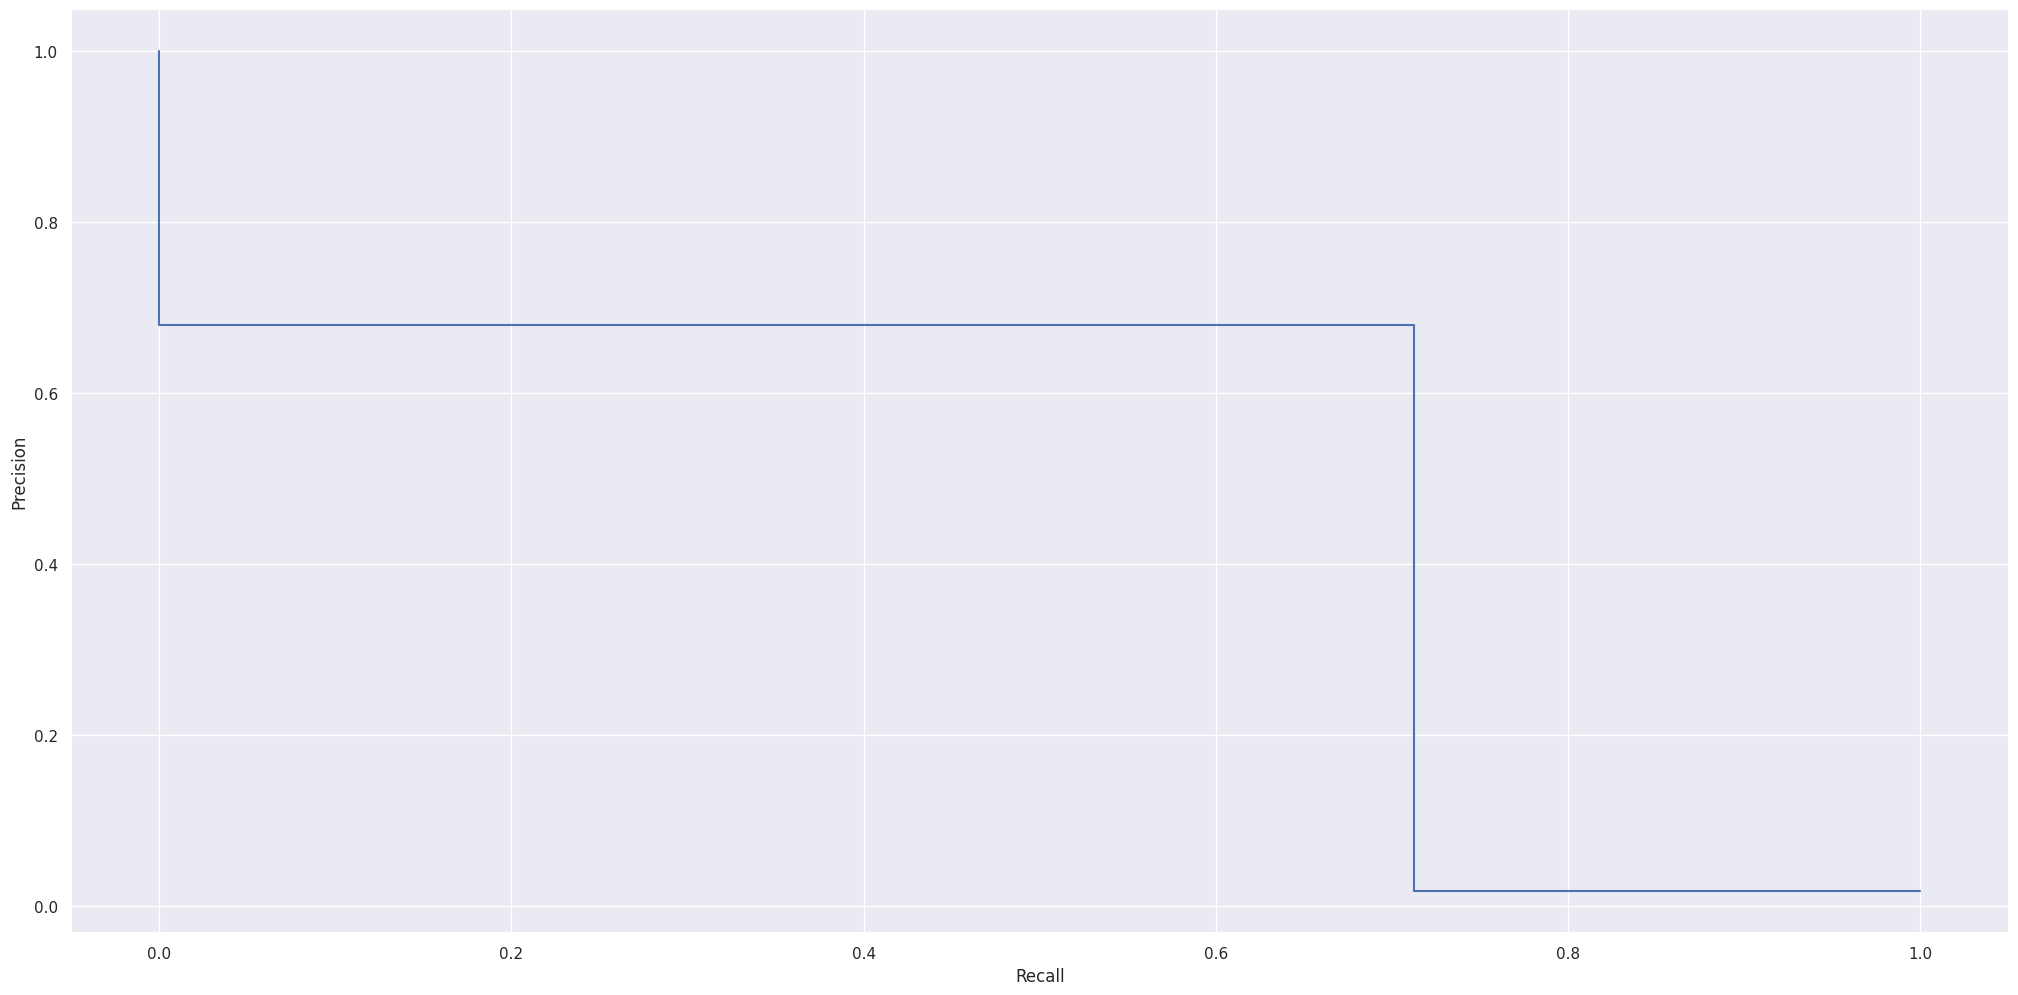

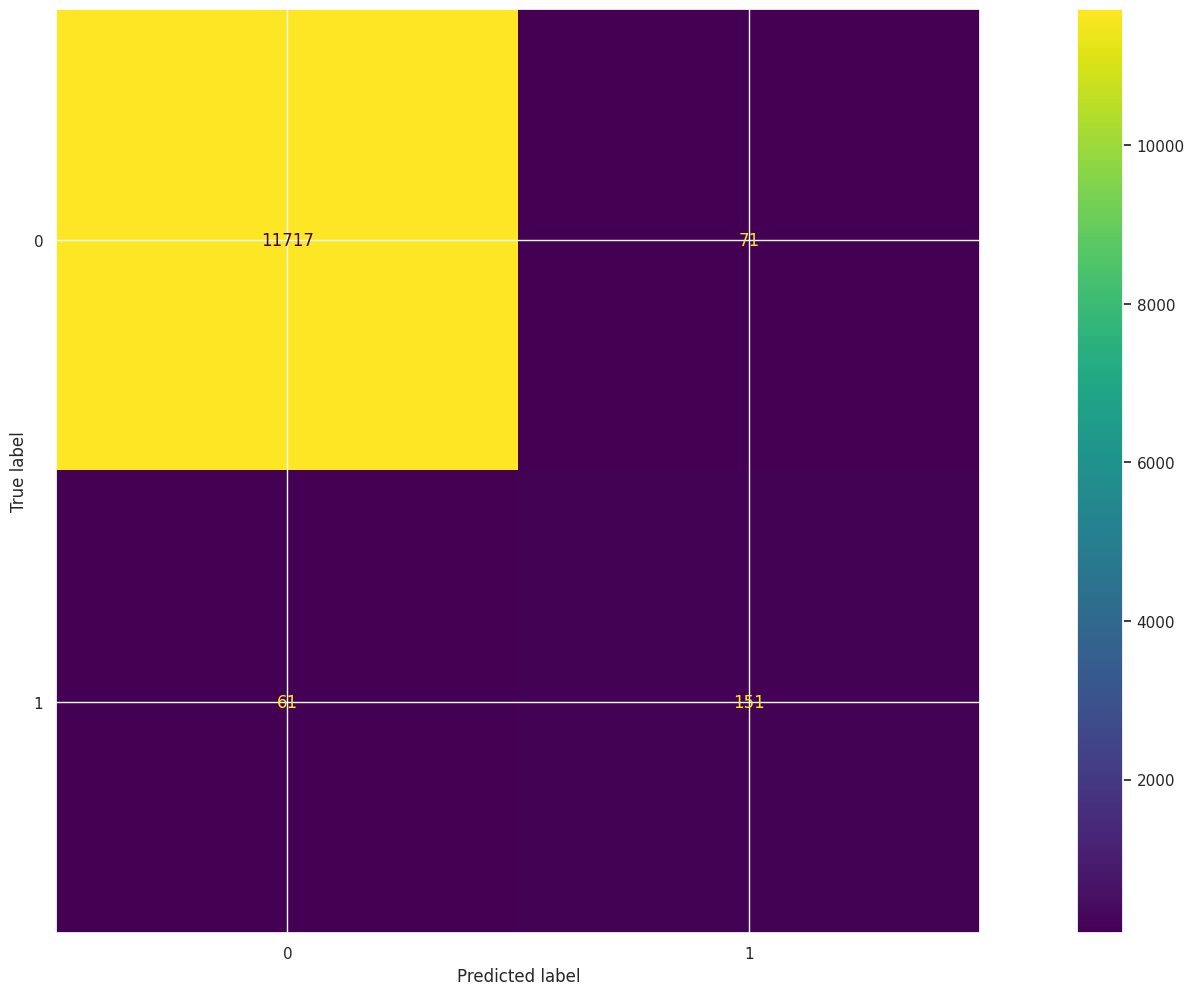

In [43]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train,y_train)
classification_metrics(knn,x_validation,y_validation)

### 7.1.1  KNN Cross Validation

In [44]:
knn_cv = cross_validation(knn,x_train,y_train,5,Verbose=False)

## 7.2 Logistic Regression 

,Model_Name,Recall,F1_Score,PRC AUC,AUC SCORE
0,LogisticRegression,0.6698,0.6469,0.7012,0.9703


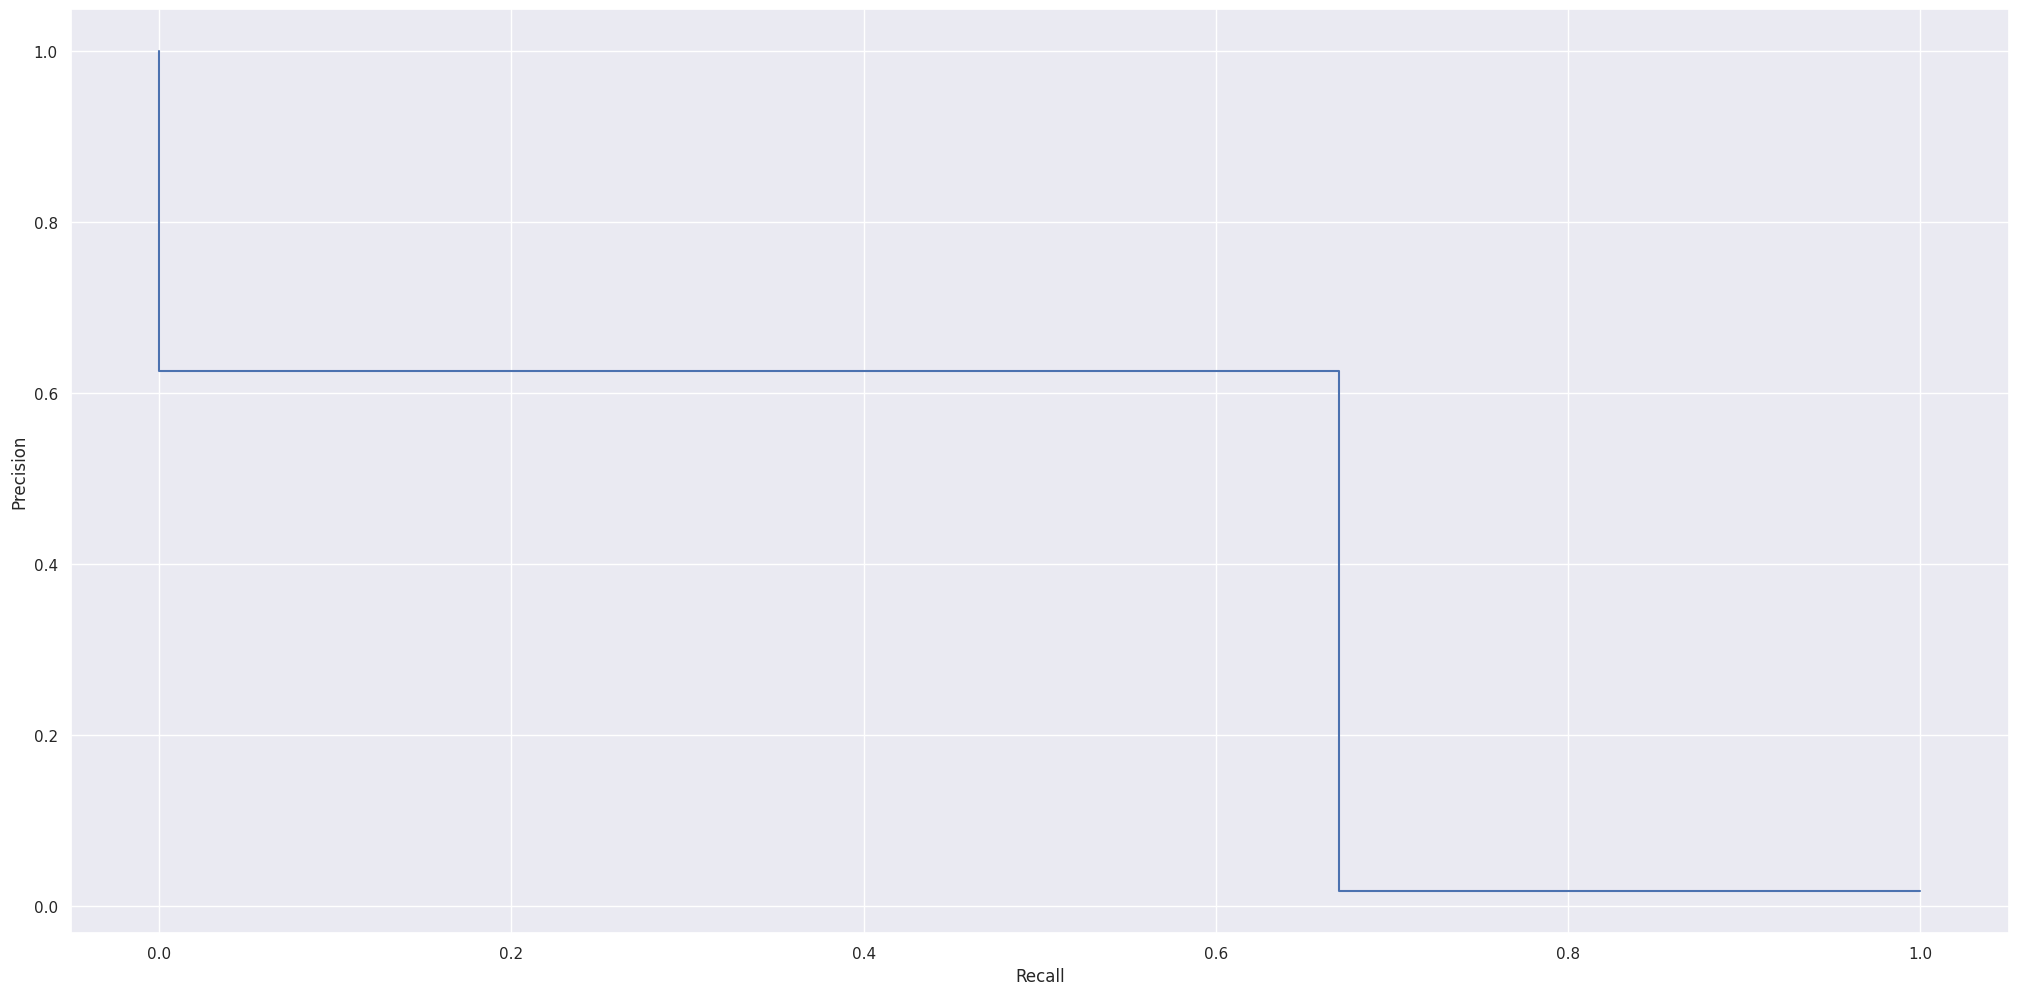

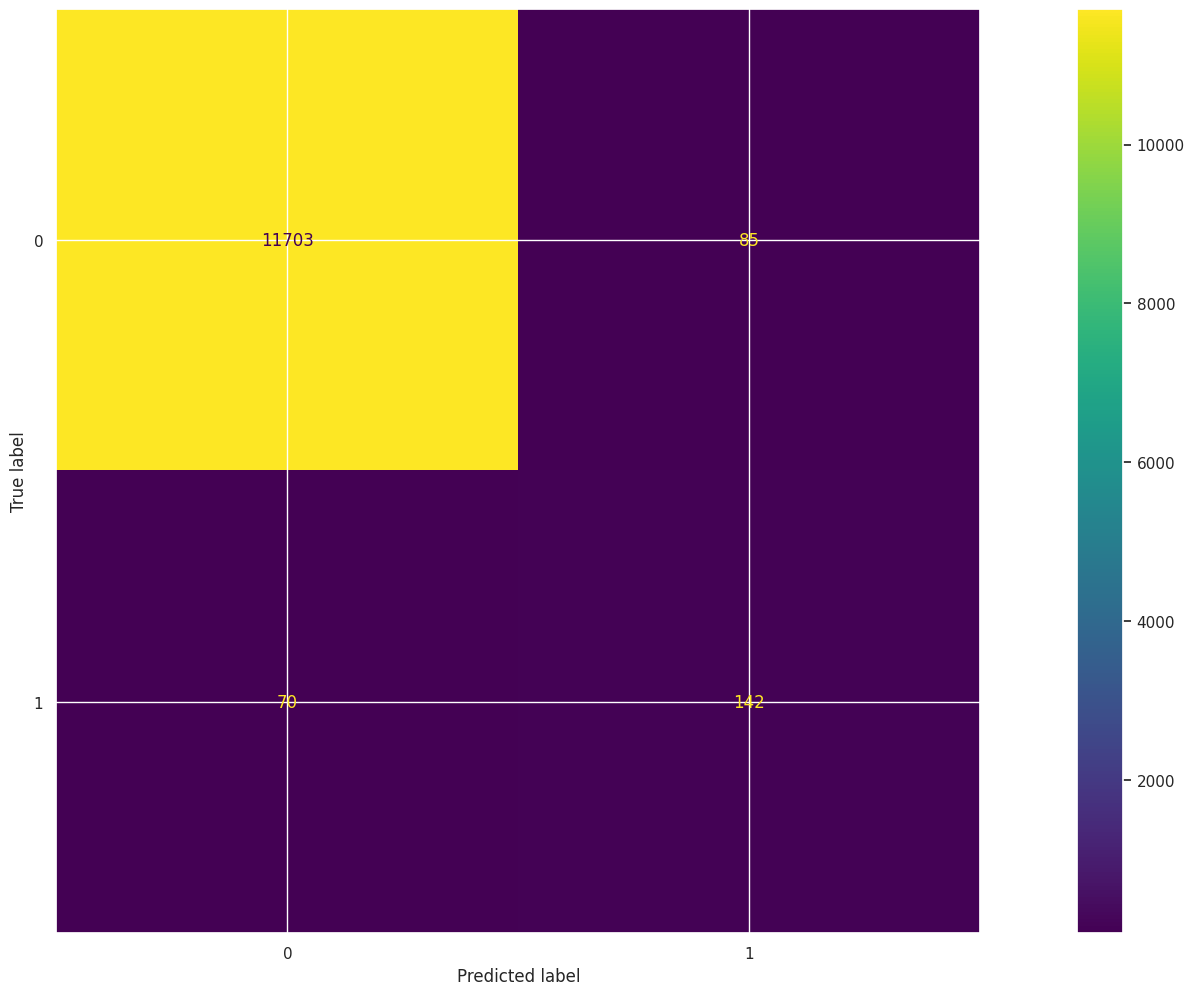

In [45]:
lr = LogisticRegression() 

lr.fit(x_train,y_train)
classification_metrics(lr,x_validation,y_validation)

### 7.2.1 Logistic Regression Cross Validation

In [46]:
lr_cv = cross_validation(lr,x_train,y_train,5,Verbose=False)

/home/jordan/Estudismo/case_bix/case_tecnico/venv_truck/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jordan/Estudismo/case_bix/case_tecnico/venv_truck/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver opti

## 7.3 Random Forest Classifier

,Model_Name,Recall,F1_Score,PRC AUC,AUC SCORE
0,RandomForestClassifier,0.7830,0.7632,0.8086,0.9804


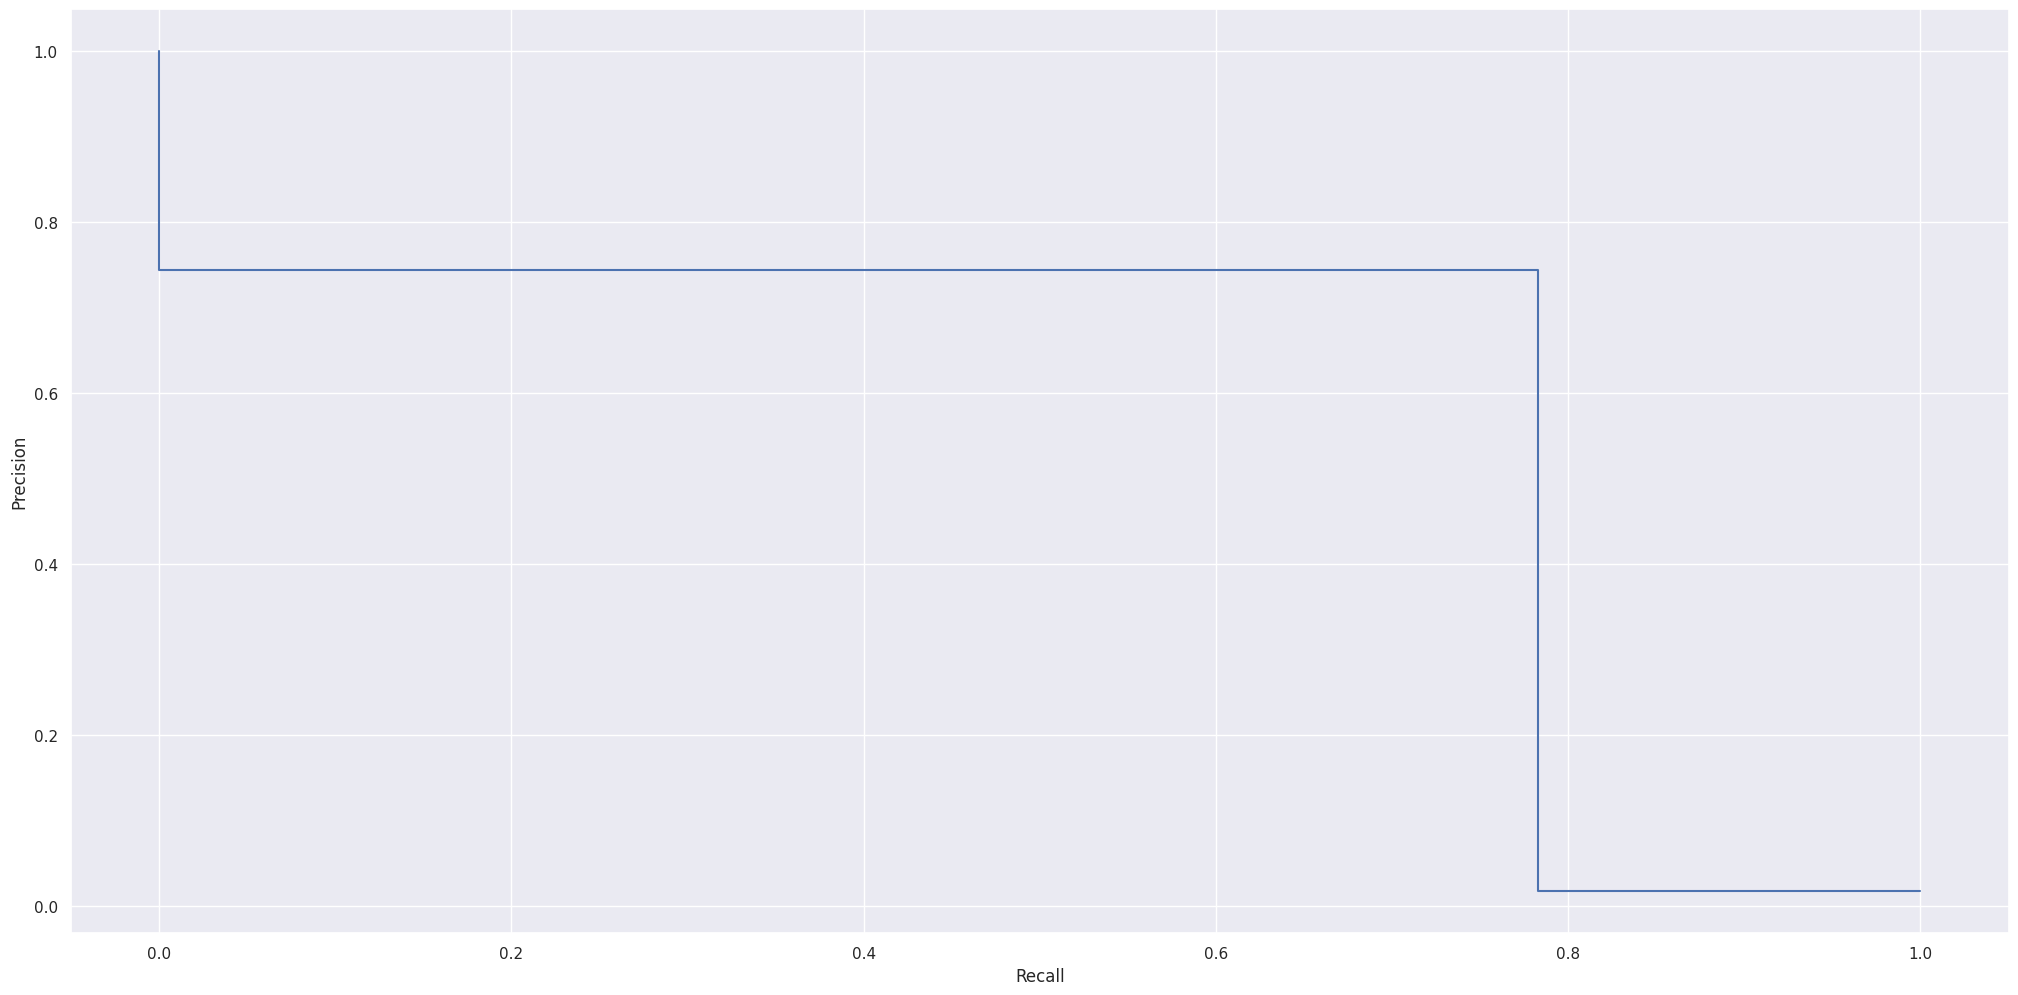

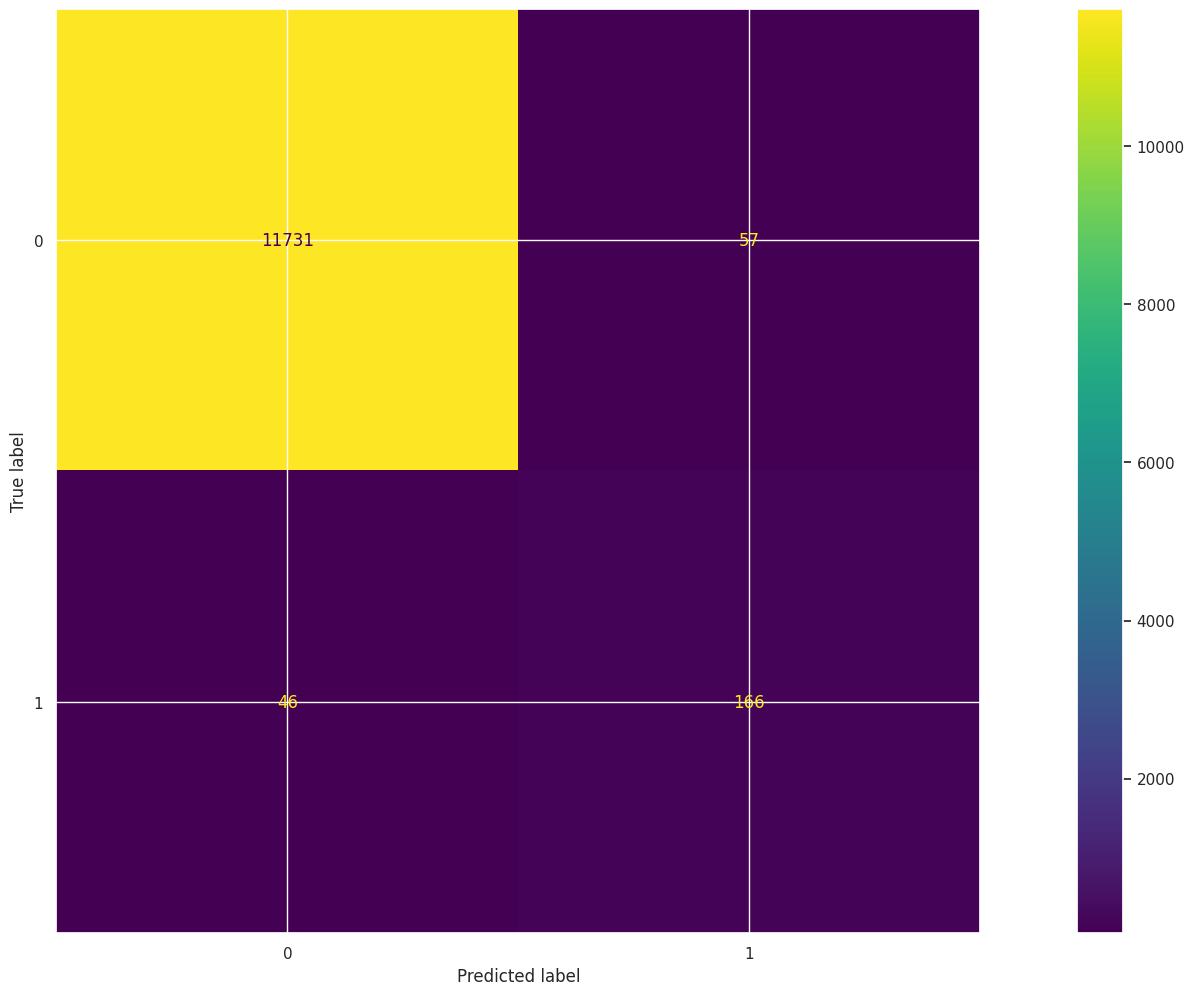

In [47]:
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(x_train,y_train)
classification_metrics(rf,x_validation,y_validation)


### 7.3.1 Random Forest CV

In [48]:
rf_cv = cross_validation(rf,x_train,y_train,5,Verbose=False)

## 7.4 LGBM Classifier

,Model_Name,Recall,F1_Score,PRC AUC,AUC SCORE
0,LGBMClassifier,0.8160,0.7706,0.8266,0.9880


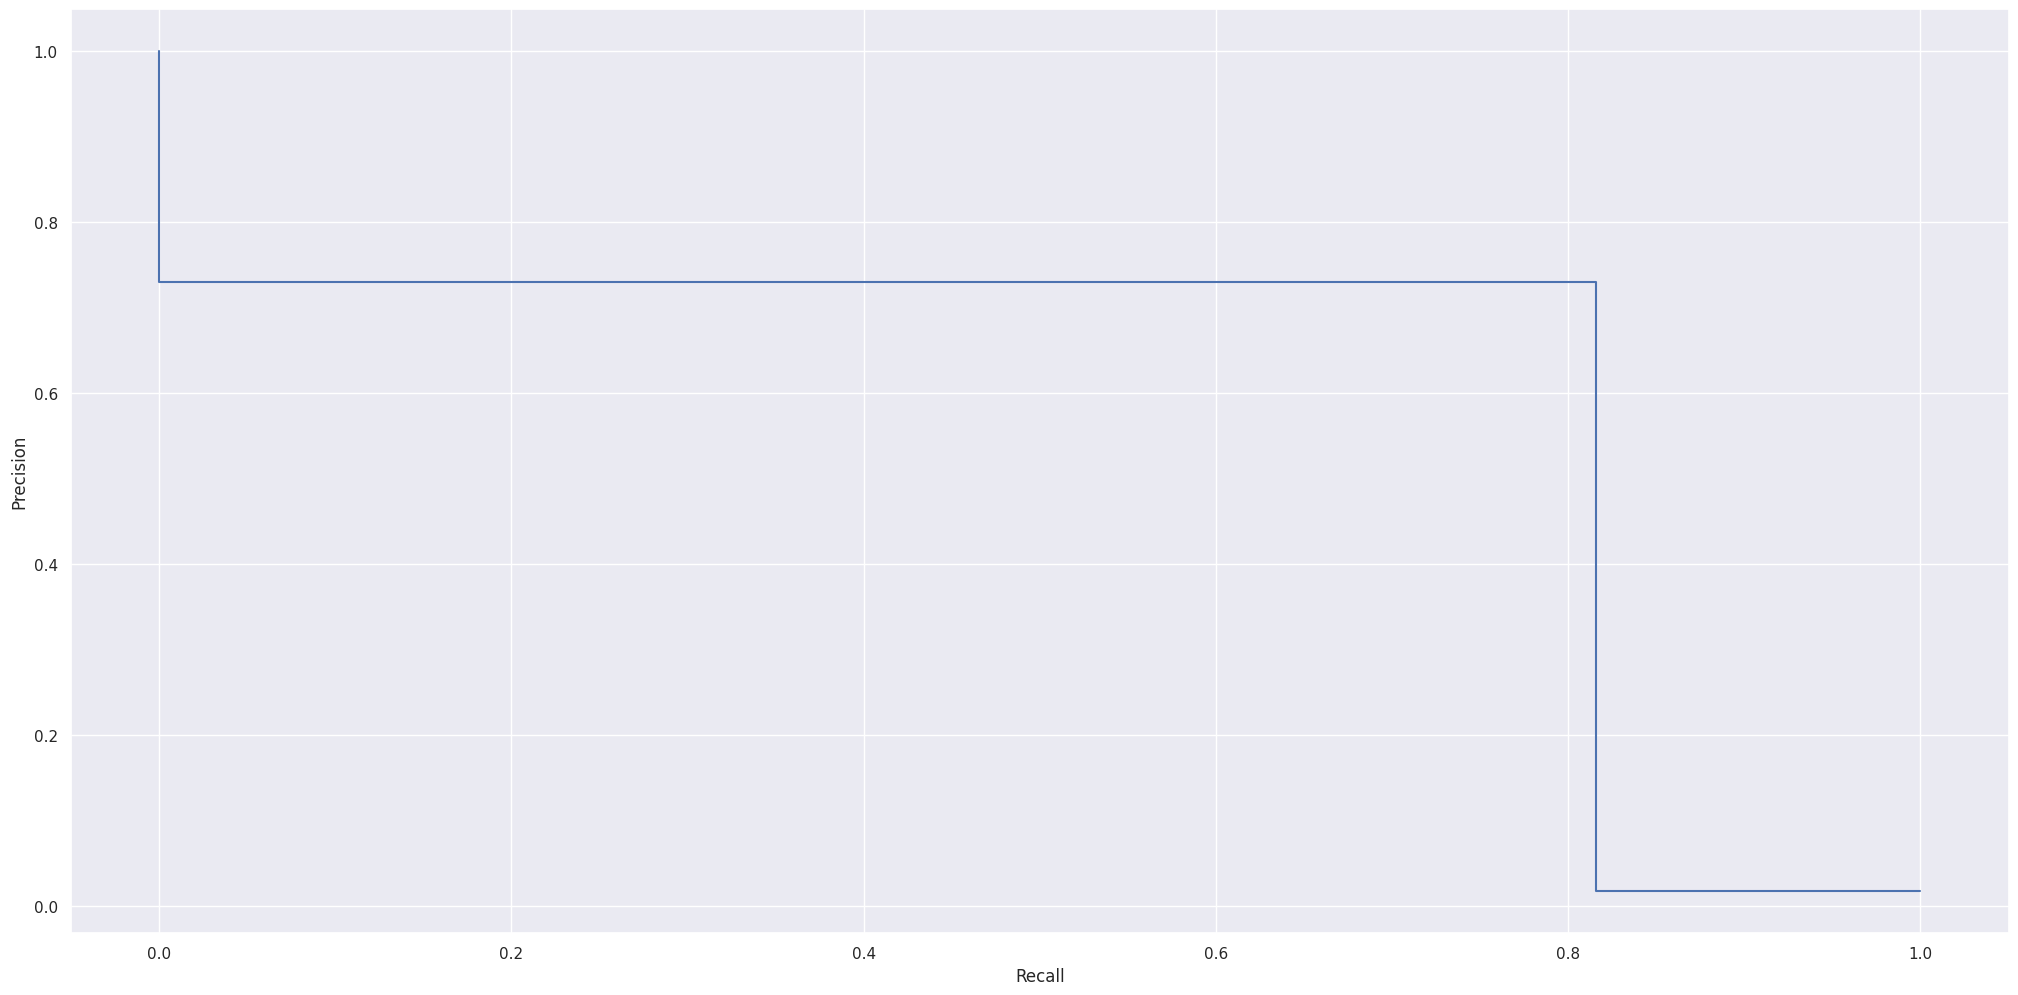

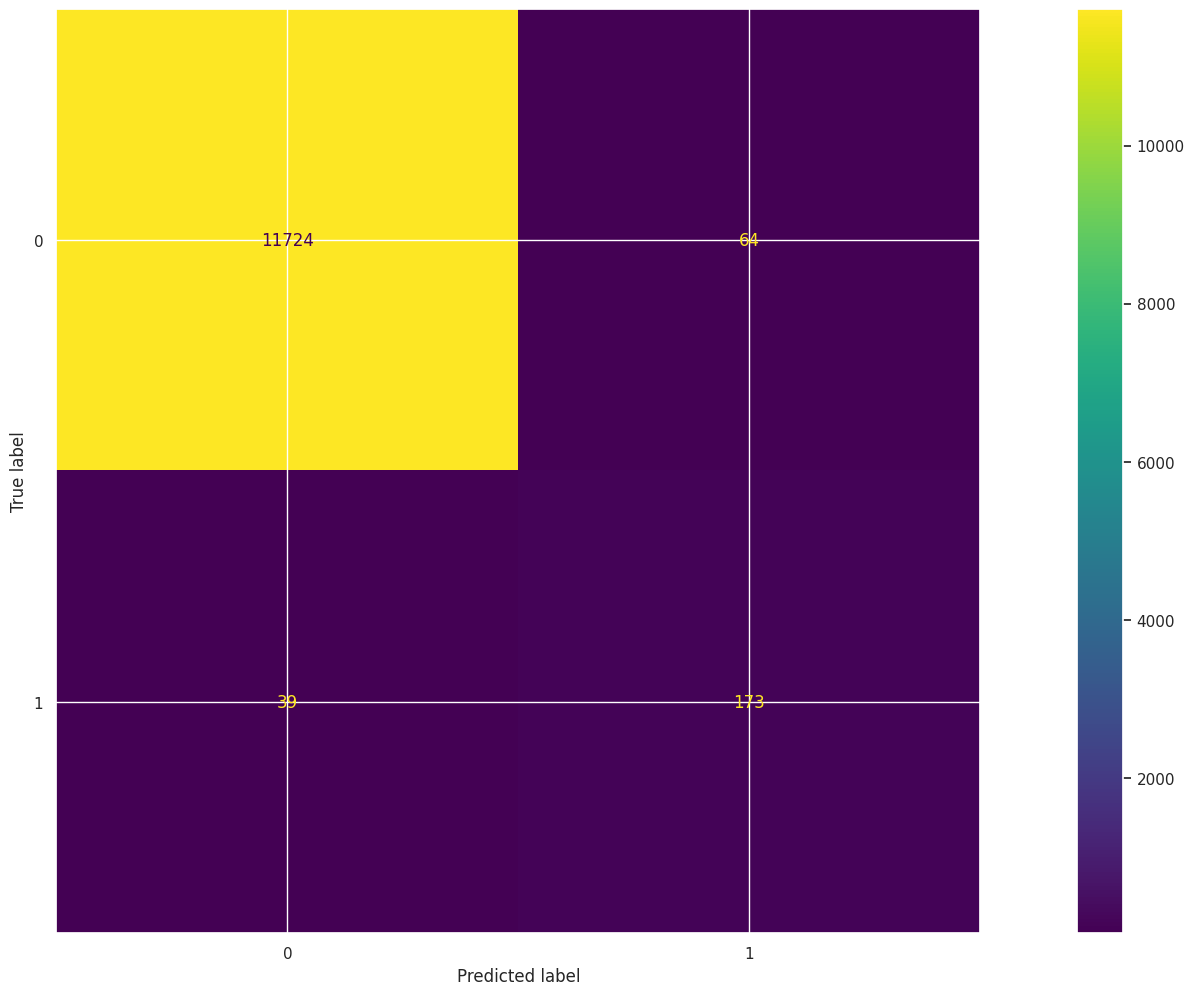

In [49]:
lgbm = LGBMClassifier()

lgbm.fit(x_train,y_train)
classification_metrics(lgbm,x_validation,y_validation)



### 7.4.1 LGBM Cross-Validation

In [50]:
lgbm_cv = cross_validation(lgbm,x_train,y_train,5,Verbose=False)

## 7.5 XGBoost Classifier

,Model_Name,Recall,F1_Score,PRC AUC,AUC SCORE
0,XGBClassifier,0.7877,0.7608,0.8264,0.9870


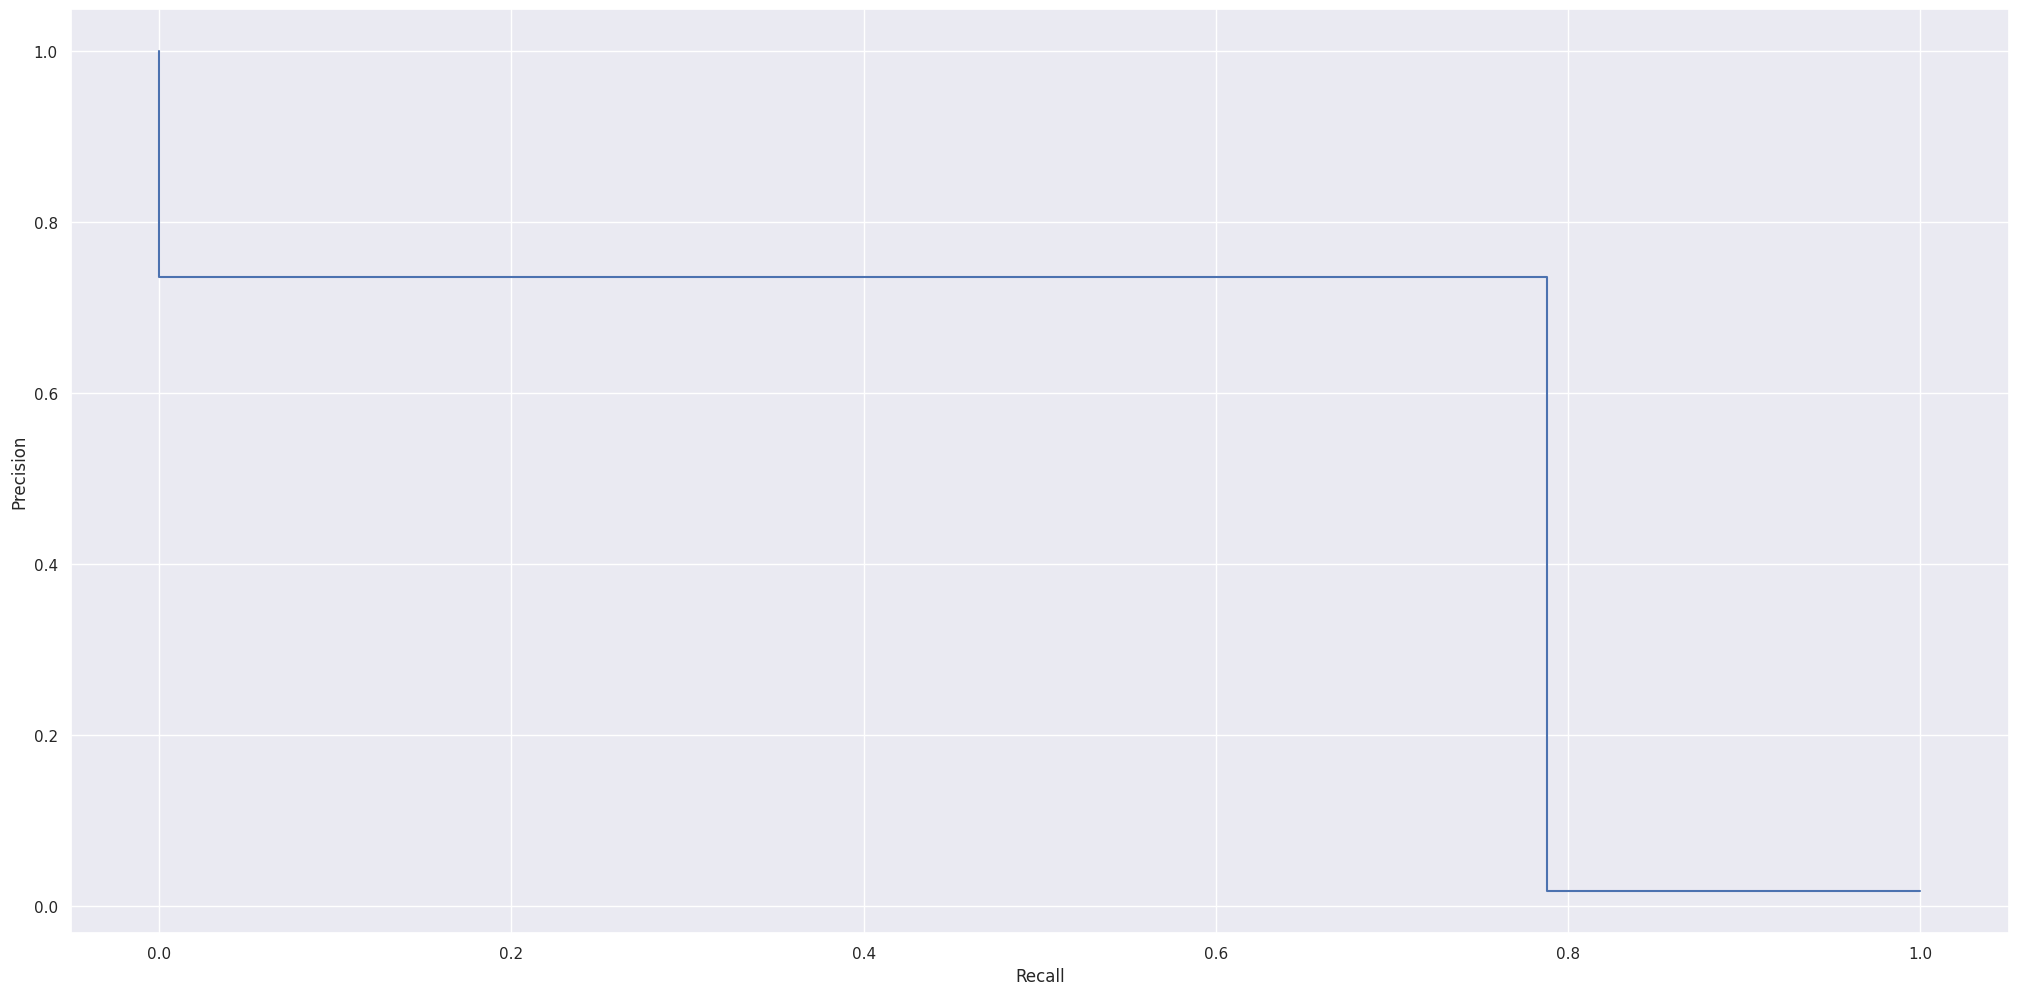

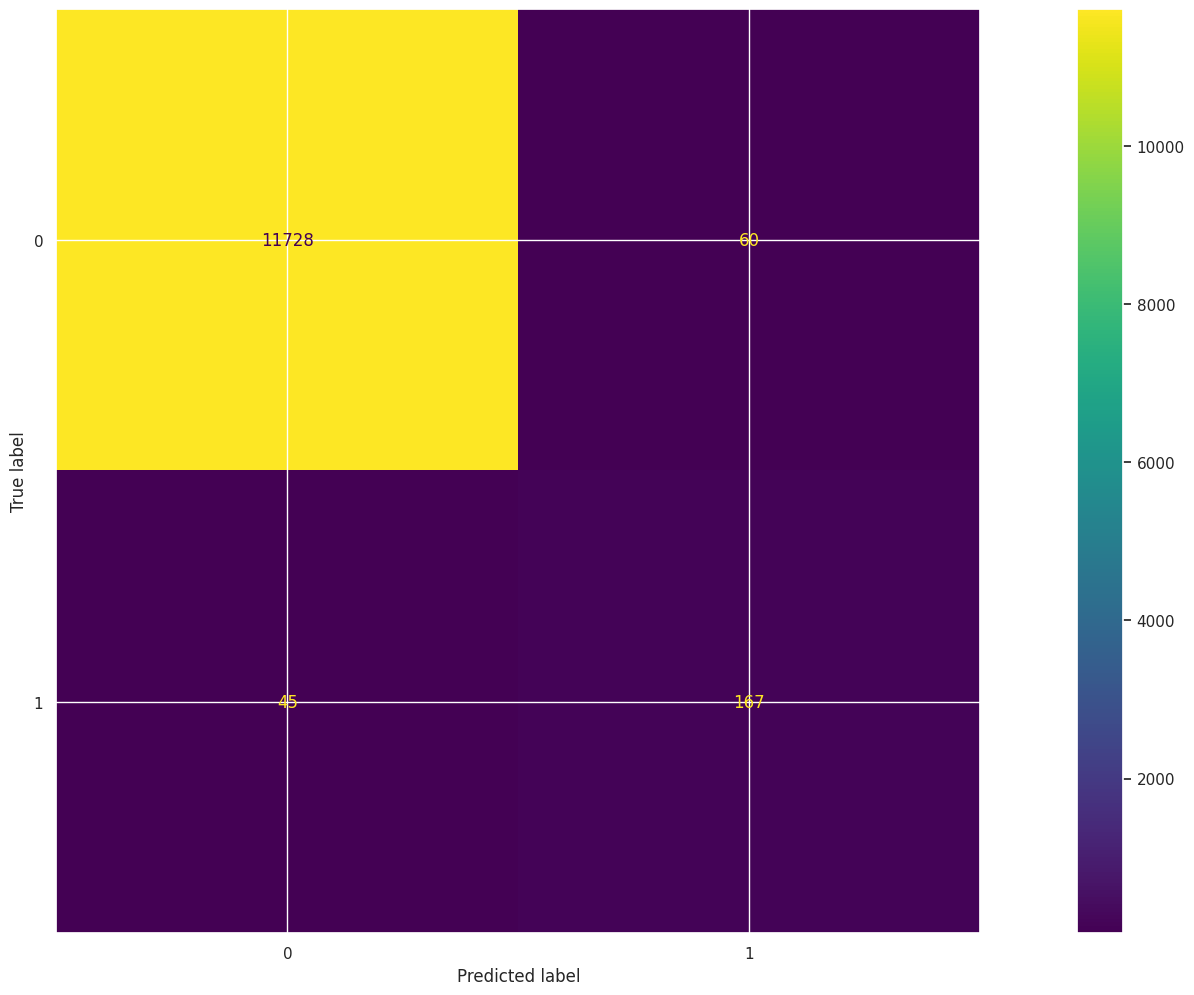

In [51]:
xgboost = XGBClassifier(n_jobs=-1)
xgboost.fit(x_train,y_train)

classification_metrics(xgboost,x_validation,y_validation)

In [52]:
xgb_cv = cross_validation(xgboost,x_train,y_train,5,Verbose=False)

## 7.6 Compare Model Perfomance


### 7.6.1 Real Perfomance - Cross Validation 

In [53]:
# FEATURE SELECTION (39) + STANDART SCALAR
model_results_cv = pd.DataFrame()
model_results_cv = pd.concat([knn_cv,lr_cv,rf_cv,lgbm_cv,xgb_cv]) 
model_results_cv.sort_values('PRC AUC',ascending=False)

,Model Name,Recall,F1 Score,PRC AUC,ROC AUC
0,XGBClassifier,0.8160,0.8647,0.9271,0.9917
0,RandomForestClassifier,0.8033,0.8599,0.9170,0.9880
0,LGBMClassifier,0.8160,0.8614,0.9132,0.9907
0,LogisticRegression,0.6802,0.7511,0.8175,0.9811
0,KNeighborsClassifier,0.7068,0.7899,0.7925,0.9388


# 8.0 Hyper Parameter Fine Tuning

In [54]:
import optuna

## 8.1 XGBoost 

In [55]:
# def xgb_objective(trial):
    
#     n_estimators_         = trial.suggest_int('n_estimators', 150,350)
#     eta_                  = trial.suggest_float('eta', 0.01,0.3)
#     max_depth_            = trial.suggest_int('max_depth',5,10)
#     subsample_            = trial.suggest_float('subsample',0.3,1.0)
#     colsample_bytree_     = trial.suggest_float('colsample_bytree',0.5,0.7)

    
#     model = XGBClassifier(n_estimators=n_estimators_,eta=eta_,max_depth=max_depth_,colsample_bytree=colsample_bytree_,subsample=subsample_).fit(x_train,y_train)
    
#     yhat_xgboost_proba =  model.predict_proba(x_validation)
#     yhat_xgboost = model.predict(x_validation)
    
#     # Metrics 
#     recall = recall_score(y_validation,yhat_xgboost)
    
#     # PRC AUC
#     prc_auc = average_precision_score(y_validation, yhat_xgboost_proba[:,1])
  
    
#     return recall

# study = optuna.create_study(direction='maximize')
# study.optimize(xgb_objective,n_trials=650)

# trial = study.best_trial

# print('Best Recall for XGBoost: {}'.format(trial.value))
# print('Best hyperparam: {}'.format(trial.params))

## 8.2 LGBM

In [56]:
# def lgbm_objective(trial):
    
# #     num_leaves = trial.suggest_int('num_leaves')
#     max_depth = trial.suggest_int('max_depth',3,8)
#     min_split_gain = trial.suggest_float('min_split_gain',0.01,0.1)
#     min_child_weight = trial.suggest_int('min_child_weight',10,50)
#     min_child_samples = trial.suggest_int('min_child_samples',1,7)
#     subsample = trial.suggest_float('subsample',0.1,1)
#     colsample_bytree = trial.suggest_float('colsample_bytree',0.1,1.0)
#     n_estimators = trial.suggest_int('n_estimators',100,500)
    
#     lgbm = LGBMClassifier(num_leaves= 2** max_depth,max_depth=max_depth,min_split_gain = min_split_gain,min_child_weight = min_child_weight,min_child_samples = min_child_samples,
#                           subsample = subsample ,colsample_bytree = colsample_bytree,n_estimators = n_estimators).fit(x_train,y_train)

    
#     yhat_lgbm_proba =  lgbm.predict_proba(x_validation)
#     yhat_lgbm = lgbm.predict(x_validation)
    
#     # Metrics 
#     recall = recall_score(y_validation,yhat_lgbm)
    
#     # PRC AUC
#     prc_auc = average_precision_score(y_validation, yhat_lgbm_proba[:,1])
    

#     return recall

# study = optuna.create_study(direction='maximize')
# study.optimize(lgbm_objective,n_trials=300);

# trial = study.best_trial

# print('Best Recall Score: {}'.format(trial.value))
# print('Best hyperparam: {}'.format(trial.params))

In [57]:
# Best hyperparam: {'max_depth': 7, 'min_split_gain': 0.0664109816983749, 'min_child_weight': 12, 'min_child_samples': 7, 'subsample': 0.5536618883344867, 'colsample_bytree': 0.6772316443912649, 'n_estimators': 500}

# 9.0 Final Model - Final Model XGBoost

## 9.1 Test Dataset Transformation


In [58]:
df_test = pd.read_csv('../data/air_system_present_year.csv')

In [59]:
df_test['class'].value_counts()

neg    15625
pos      375
Name: class, dtype: int64

In [60]:
df_test = df_test.replace('na','0')
df_test = df_test.astype({col: float for col in df1.columns[1:]})
df_test['class'] = df_test['class'].apply(lambda x: 1 if x == 'pos' else 0)

In [61]:
x_test = df_test.drop(['class'],axis=1)
y_test = df_test['class']

In [62]:
x_test.head()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,60.0000,0.0000,20.0000,12.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2682.0000,4736.0000,3862.0000,1846.0000,0.0000,0.0000,0.0000,3976.0000,0.0000,0.0000,0.0000,1520.0000,2374.0000,11516.0000,9480.0000,111258.0000,470.0000,0.0000,0.0000,0.0000,0.0000,58.0000,26.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,13124.0000,2.0000,1956.0000,434.0000,76.0000,174.0000,190.0000,6198.0000,1148.0000,2948.0000,2.0000,0.0000,8762.0000,2566.0000,480.0000,380.0000,196.0000,516.0000,86.0000,66.0000,74.0000,0.0000,124340.0000,4.0000,6.0000,4.0000,0.0000,3976.0000,318.0000,107662.0000,3458.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,110980.0000,59.5300,124340.0000,124340.0000,184970.0000,54.0000,686.0000,12246.0000,123880.0000,13196.0000,1209600.0000,598.0000,0.0000,6.0000,0.0000,5913.6000,0.0000,5851.2000,6.0000,30.0000,0.0000,2.0000,5512.0000,4674.0000,1388.0000,1508.0000,38.0000,4.0000,0.0000,0.0000,8.0000,12.0000,124340.0000,0.0000,1550.0000,14.0000,36.0000,26.0000,920.0000,430.0000,7650.0000,2294.0000,206.0000,0.0000,22.0000,42.0000,5336.0000,1276.0000,0.0000,0.0000,0.0000,0.0000,6598.0000,70.0000,112.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,340.0000,0.0000,0.0000,1100.0000,574.0000,232.0000,66.0000,780.0000,882.0000,0.0000,4.0000,0.0000,0.0000,0.0000,465.5000,90.0000,7502.0000,3156.0000,1098.0000,138.0000,412.0000,654.0000,78.0000,88.0000,0.0000,0.0000,0.0000,0.0000
1,82.0000,0.0000,68.0000,40.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,748.0000,12594.0000,3636.0000,0.0000,0.0000,0.0000,5244.0000,0.0000,60.0000,0.0000,0.0000,0.0000,23174.0000,18166.0000,23686.0000,1270.0000,0.0000,0.0000,0.0000,0.0000,12.0000,82.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,692.0000,16286.0000,0.0000,280.0000,44.0000,50.0000,1274.0000,866.0000,3362.0000,11102.0000,0.0000,0.0000,0.0000,12564.0000,1756.0000,638.0000,276.0000,172.0000,132.0000,812.0000,308.0000,192.0000,128.0000,46894.0000,4.0000,2.0000,38.0000,0.0000,5244.0000,360.0000,20520.0000,3134.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,23320.0000,81.8900,46894.0000,46894.0000,48324.0000,68.0000,0.0000,4486.0000,46480.0000,17050.0000,1209600.0000,726.0000,2.0000,4.0000,0.0000,7224.9600,0.0000,7768.3200,0.0000,42.0000,0.0000,0.0000,4.0000,7064.0000,6200.0000,2452.0000,1246.0000,12.0000,0.0000,0.0000,14.0000,54.0000,46894.0000,0.0000,2202.0000,28.0000,114.0000,350.0000,700.0000,1708.0000,9622.0000,2174.0000,80.0000,0.0000,80.0000,206.0000,7802.0000,1466.0000,0.0000,0.0000,0.0000,0.0000,7918.0000,78.0000,40.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,352.0000,0.0000,0.0000,3996.0000,584.0000,200.0000,62.0000,37580.0000,3756.0000,6368.0000,36.0000,0.0000,0.0000,0.0000,2.8600,102.0000,10040.0000,3310.0000,1068.0000,276.0000,1620.0000,116.0000,86.

## 9.2 Scaling Test Dataset

In [63]:
x_test_scaler = sc.transform(x_test)
x_test_final = pd.DataFrame(x_test_scaler,columns=x_test.columns)
x_test_final = x_test_final[cols_selected]

In [64]:
# x_test_final[333] = (x_validation[94] + x_validation[70] )/ 2

In [65]:
# Join Train + Validation for Final Training
x_train_final = pd.concat([x_train,x_validation],axis=0)
y_train_final = pd.concat([y_train,y_validation],axis=0)

## 9.3 Final Model

### 9.3.1 XGBoost

In [66]:
param_xgb_tuned = {'n_estimators': 254, 'eta': 0.1805009334625665, 'max_depth': 5, 'subsample': 0.41067293045952674, 'colsample_bytree': 0.6994352509806072} # 46

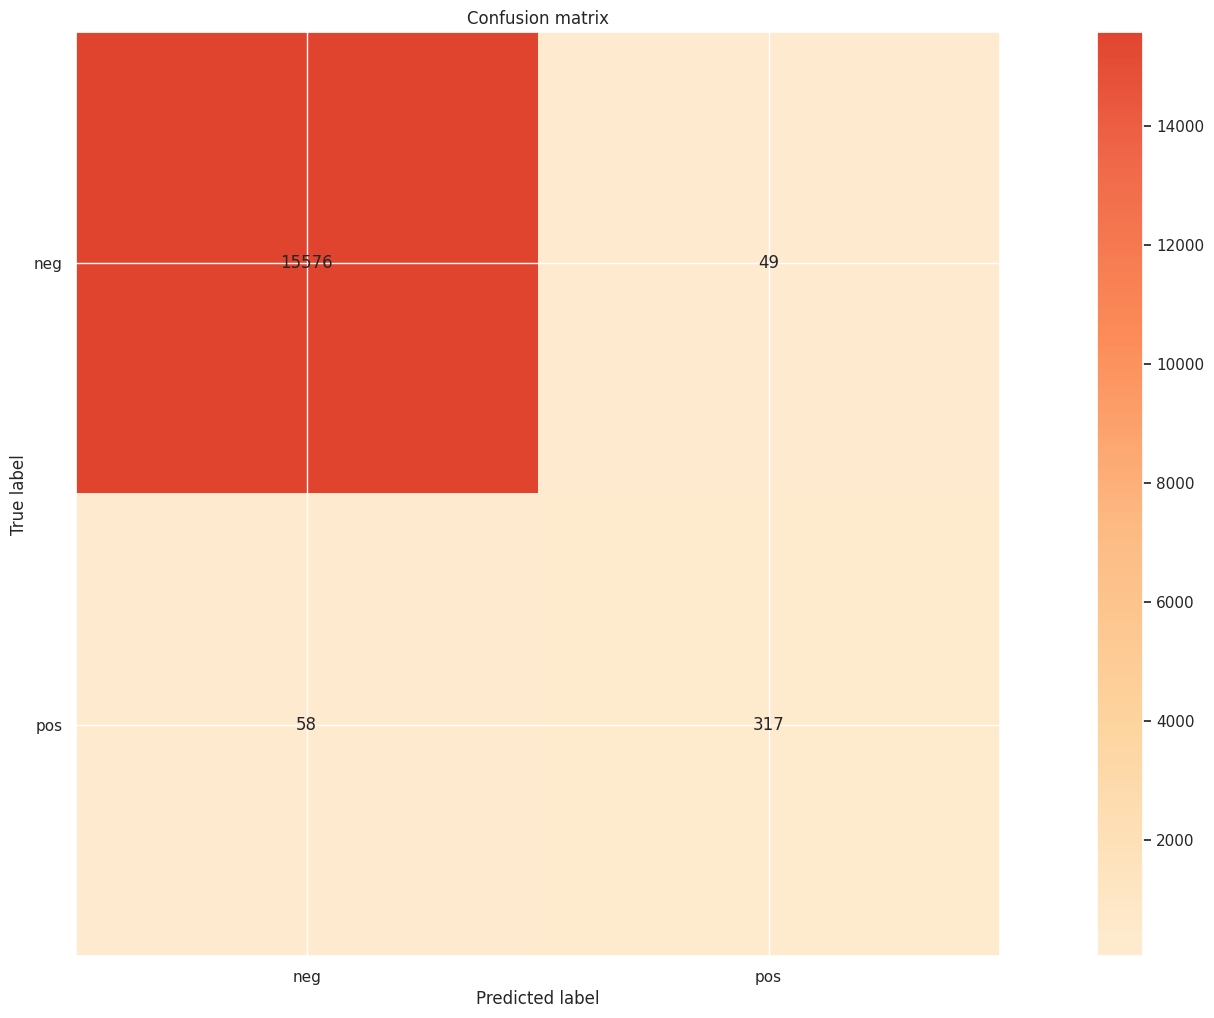

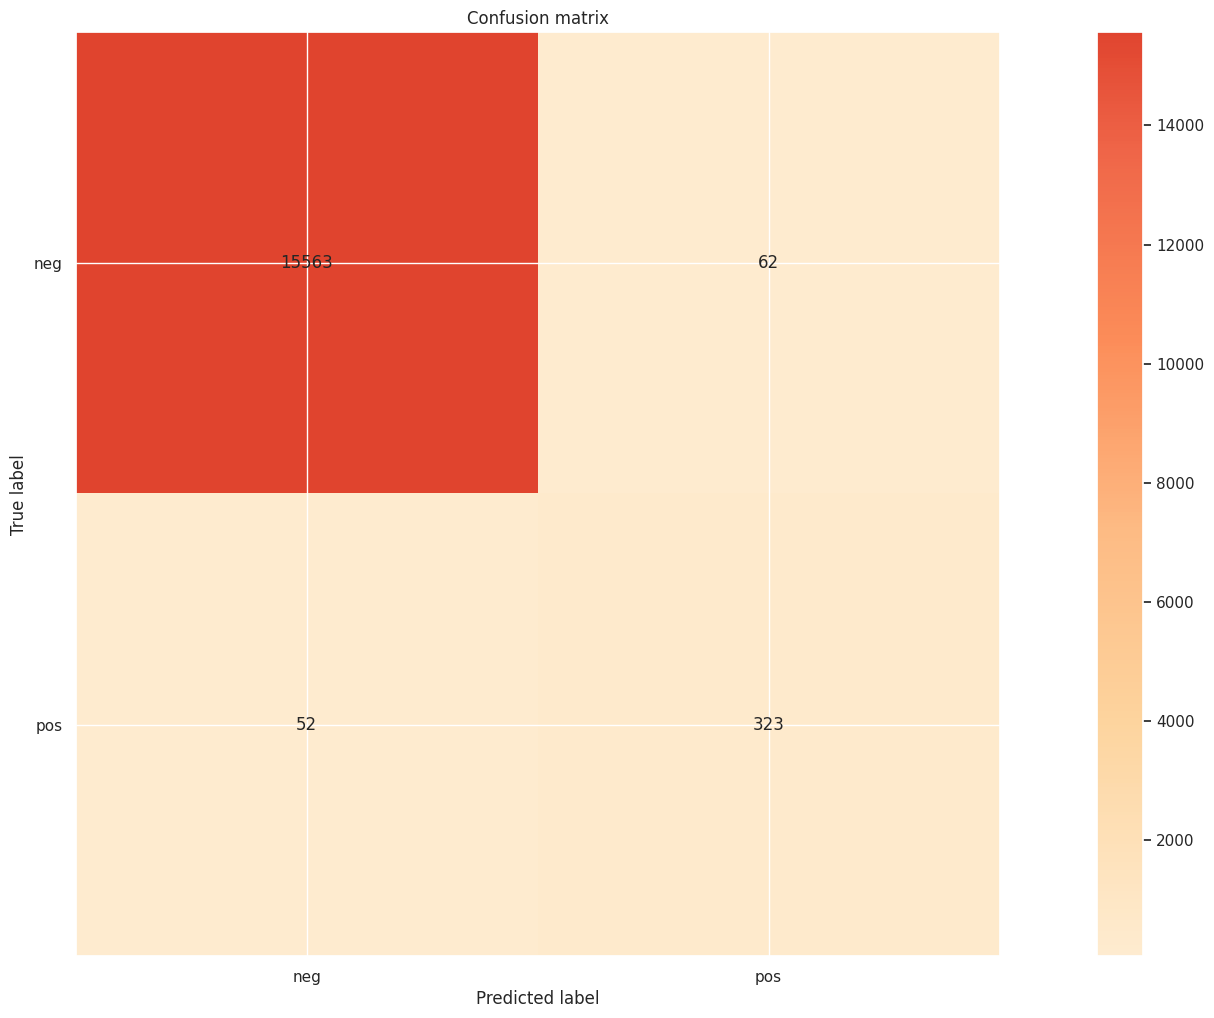

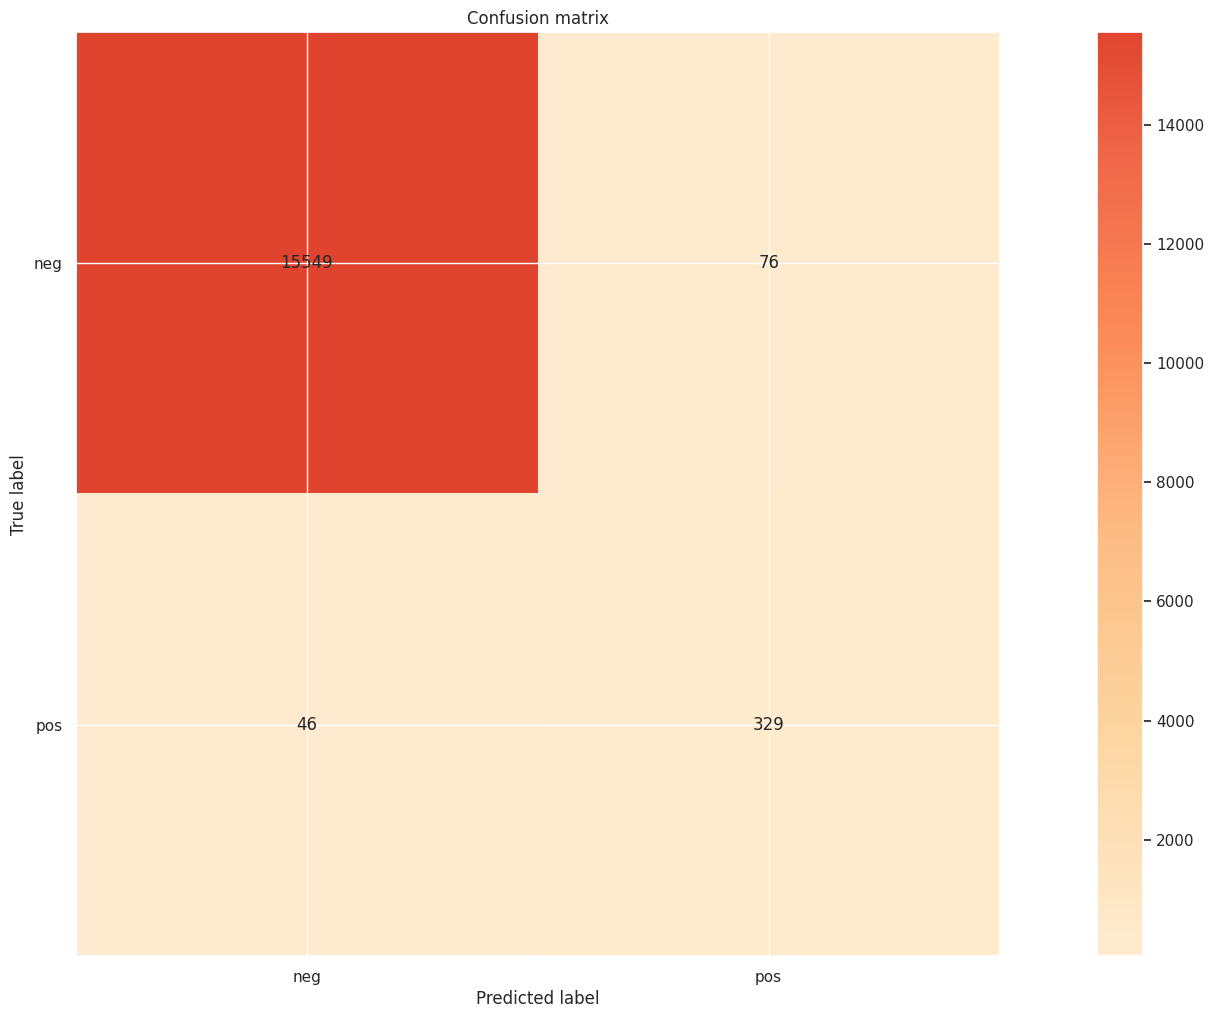

In [68]:
xgb = XGBClassifier(n_estimators= param_xgb_tuned['n_estimators'], eta= param_xgb_tuned['eta'], max_depth= param_xgb_tuned['max_depth'], 
                    subsample= param_xgb_tuned['subsample'], colsample_bytree= param_xgb_tuned['colsample_bytree']).fit(x_train_final,y_train_final)

# pickle.dump(xgb,open('../model/xgboost_classifier_final_model.pkl','wb'))

yhat = xgb.predict(x_test_final)
yhat_proba =  xgb.predict_proba(x_test_final) 


# Confusion Matrix
# Without selected Threshold
cm_threshold = plot.ConfusionMatrix.from_raw_data(y_test, yhat ,target_names = ['neg', 'pos'])

# # Threshold 0.4 and 0.3 
cm_threshold_1 = plot.ConfusionMatrix.from_raw_data(y_test, yhat_proba[:,1] >= 0.4,target_names = ['neg', 'pos'])
cm_threshold_2 = plot.ConfusionMatrix.from_raw_data(y_test, yhat_proba[:,1] >= 0.3,target_names = ['neg', 'pos'])



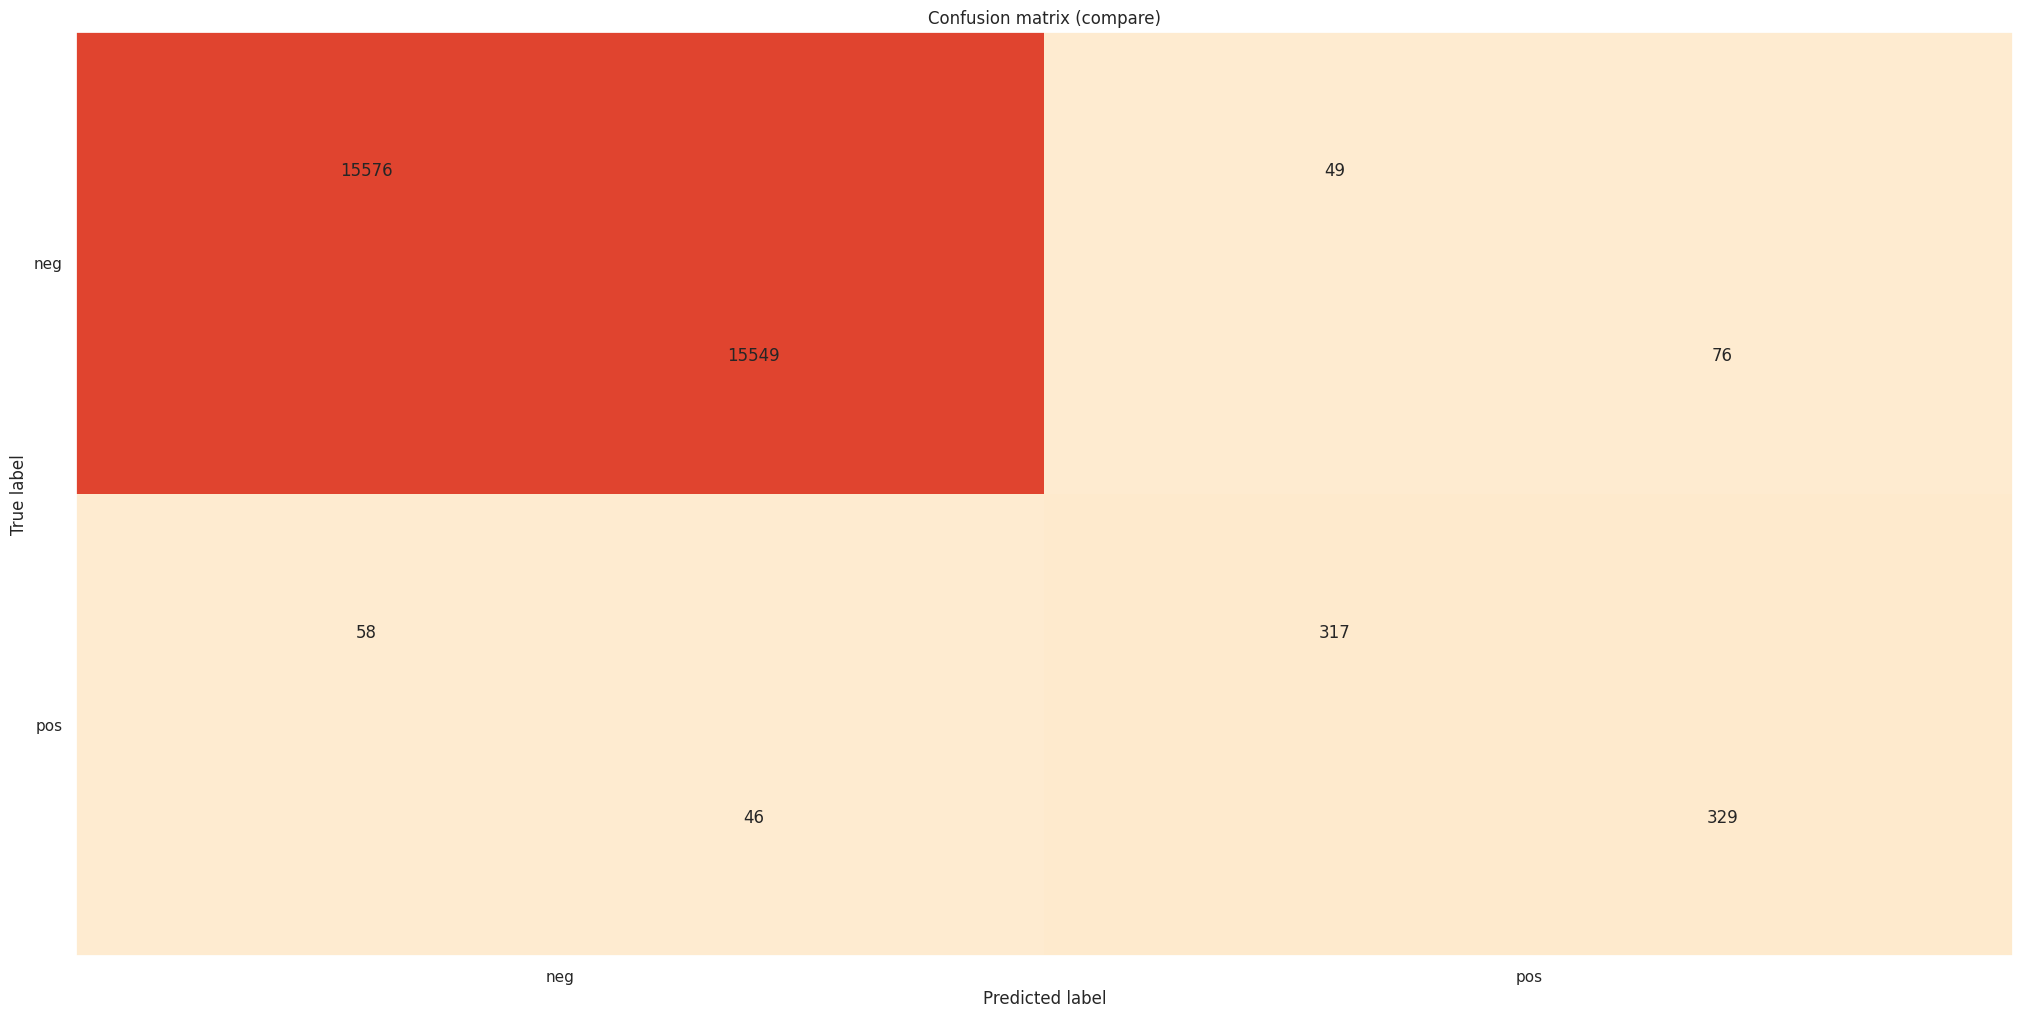

In [69]:
cm_threshold + cm_threshold_2

# 10.0 Deploy to Production

## 10.1 API TESTER

In [72]:
x_test.head()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,60.0000,0.0000,20.0000,12.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2682.0000,4736.0000,3862.0000,1846.0000,0.0000,0.0000,0.0000,3976.0000,0.0000,0.0000,0.0000,1520.0000,2374.0000,11516.0000,9480.0000,111258.0000,470.0000,0.0000,0.0000,0.0000,0.0000,58.0000,26.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,13124.0000,2.0000,1956.0000,434.0000,76.0000,174.0000,190.0000,6198.0000,1148.0000,2948.0000,2.0000,0.0000,8762.0000,2566.0000,480.0000,380.0000,196.0000,516.0000,86.0000,66.0000,74.0000,0.0000,124340.0000,4.0000,6.0000,4.0000,0.0000,3976.0000,318.0000,107662.0000,3458.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,110980.0000,59.5300,124340.0000,124340.0000,184970.0000,54.0000,686.0000,12246.0000,123880.0000,13196.0000,1209600.0000,598.0000,0.0000,6.0000,0.0000,5913.6000,0.0000,5851.2000,6.0000,30.0000,0.0000,2.0000,5512.0000,4674.0000,1388.0000,1508.0000,38.0000,4.0000,0.0000,0.0000,8.0000,12.0000,124340.0000,0.0000,1550.0000,14.0000,36.0000,26.0000,920.0000,430.0000,7650.0000,2294.0000,206.0000,0.0000,22.0000,42.0000,5336.0000,1276.0000,0.0000,0.0000,0.0000,0.0000,6598.0000,70.0000,112.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,340.0000,0.0000,0.0000,1100.0000,574.0000,232.0000,66.0000,780.0000,882.0000,0.0000,4.0000,0.0000,0.0000,0.0000,465.5000,90.0000,7502.0000,3156.0000,1098.0000,138.0000,412.0000,654.0000,78.0000,88.0000,0.0000,0.0000,0.0000,0.0000
1,82.0000,0.0000,68.0000,40.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,748.0000,12594.0000,3636.0000,0.0000,0.0000,0.0000,5244.0000,0.0000,60.0000,0.0000,0.0000,0.0000,23174.0000,18166.0000,23686.0000,1270.0000,0.0000,0.0000,0.0000,0.0000,12.0000,82.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,692.0000,16286.0000,0.0000,280.0000,44.0000,50.0000,1274.0000,866.0000,3362.0000,11102.0000,0.0000,0.0000,0.0000,12564.0000,1756.0000,638.0000,276.0000,172.0000,132.0000,812.0000,308.0000,192.0000,128.0000,46894.0000,4.0000,2.0000,38.0000,0.0000,5244.0000,360.0000,20520.0000,3134.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,23320.0000,81.8900,46894.0000,46894.0000,48324.0000,68.0000,0.0000,4486.0000,46480.0000,17050.0000,1209600.0000,726.0000,2.0000,4.0000,0.0000,7224.9600,0.0000,7768.3200,0.0000,42.0000,0.0000,0.0000,4.0000,7064.0000,6200.0000,2452.0000,1246.0000,12.0000,0.0000,0.0000,14.0000,54.0000,46894.0000,0.0000,2202.0000,28.0000,114.0000,350.0000,700.0000,1708.0000,9622.0000,2174.0000,80.0000,0.0000,80.0000,206.0000,7802.0000,1466.0000,0.0000,0.0000,0.0000,0.0000,7918.0000,78.0000,40.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,352.0000,0.0000,0.0000,3996.0000,584.0000,200.0000,62.0000,37580.0000,3756.0000,6368.0000,36.0000,0.0000,0.0000,0.0000,2.8600,102.0000,10040.0000,3310.0000,1068.0000,276.0000,1620.0000,116.0000,86.

In [73]:
df_test = pd.DataFrame()

In [74]:
df_test['score'] = yhat_proba[:,1]

In [75]:
x = df_test[df_test['score'] > 0.5]
x.shape

(366, 1)

In [76]:
y = df_test[df_test['score'] <= 0.5]
y.shape

(15634, 1)

In [77]:
df_test.sort_values('score',ascending=False).head(50)

,score
3581,1.0000
2528,1.0000
4405,1.0000
14594,1.0000
9396,1.0000
4009,1.0000
9418,1.0000
1796,1.0000
6258,0.9999
9196,0.9999


In [78]:
import json
import requests

In [79]:
x_test.shape

(16000, 170)

In [80]:
df_test = x_test.copy()

In [81]:
df_test.head()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,60.0000,0.0000,20.0000,12.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2682.0000,4736.0000,3862.0000,1846.0000,0.0000,0.0000,0.0000,3976.0000,0.0000,0.0000,0.0000,1520.0000,2374.0000,11516.0000,9480.0000,111258.0000,470.0000,0.0000,0.0000,0.0000,0.0000,58.0000,26.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,13124.0000,2.0000,1956.0000,434.0000,76.0000,174.0000,190.0000,6198.0000,1148.0000,2948.0000,2.0000,0.0000,8762.0000,2566.0000,480.0000,380.0000,196.0000,516.0000,86.0000,66.0000,74.0000,0.0000,124340.0000,4.0000,6.0000,4.0000,0.0000,3976.0000,318.0000,107662.0000,3458.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,110980.0000,59.5300,124340.0000,124340.0000,184970.0000,54.0000,686.0000,12246.0000,123880.0000,13196.0000,1209600.0000,598.0000,0.0000,6.0000,0.0000,5913.6000,0.0000,5851.2000,6.0000,30.0000,0.0000,2.0000,5512.0000,4674.0000,1388.0000,1508.0000,38.0000,4.0000,0.0000,0.0000,8.0000,12.0000,124340.0000,0.0000,1550.0000,14.0000,36.0000,26.0000,920.0000,430.0000,7650.0000,2294.0000,206.0000,0.0000,22.0000,42.0000,5336.0000,1276.0000,0.0000,0.0000,0.0000,0.0000,6598.0000,70.0000,112.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,340.0000,0.0000,0.0000,1100.0000,574.0000,232.0000,66.0000,780.0000,882.0000,0.0000,4.0000,0.0000,0.0000,0.0000,465.5000,90.0000,7502.0000,3156.0000,1098.0000,138.0000,412.0000,654.0000,78.0000,88.0000,0.0000,0.0000,0.0000,0.0000
1,82.0000,0.0000,68.0000,40.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,748.0000,12594.0000,3636.0000,0.0000,0.0000,0.0000,5244.0000,0.0000,60.0000,0.0000,0.0000,0.0000,23174.0000,18166.0000,23686.0000,1270.0000,0.0000,0.0000,0.0000,0.0000,12.0000,82.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,692.0000,16286.0000,0.0000,280.0000,44.0000,50.0000,1274.0000,866.0000,3362.0000,11102.0000,0.0000,0.0000,0.0000,12564.0000,1756.0000,638.0000,276.0000,172.0000,132.0000,812.0000,308.0000,192.0000,128.0000,46894.0000,4.0000,2.0000,38.0000,0.0000,5244.0000,360.0000,20520.0000,3134.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,23320.0000,81.8900,46894.0000,46894.0000,48324.0000,68.0000,0.0000,4486.0000,46480.0000,17050.0000,1209600.0000,726.0000,2.0000,4.0000,0.0000,7224.9600,0.0000,7768.3200,0.0000,42.0000,0.0000,0.0000,4.0000,7064.0000,6200.0000,2452.0000,1246.0000,12.0000,0.0000,0.0000,14.0000,54.0000,46894.0000,0.0000,2202.0000,28.0000,114.0000,350.0000,700.0000,1708.0000,9622.0000,2174.0000,80.0000,0.0000,80.0000,206.0000,7802.0000,1466.0000,0.0000,0.0000,0.0000,0.0000,7918.0000,78.0000,40.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,352.0000,0.0000,0.0000,3996.0000,584.0000,200.0000,62.0000,37580.0000,3756.0000,6368.0000,36.0000,0.0000,0.0000,0.0000,2.8600,102.0000,10040.0000,3310.0000,1068.0000,276.0000,1620.0000,116.0000,86.

In [82]:
data = json.dumps(df_test.to_dict(orient='records'))

In [84]:
# API CALL 

url = 'https://case-tecnico-air-system.onrender.com/classify/predict'
# url = 'http://0.0.0.0:5000/classify/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url,data=data,headers=header)

print('Status Code {}'.format(r.status_code))

Status Code 200


In [85]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [399]:
d1.sort_values('score_prediction',ascending=False).head(50)

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000,score_prediction
0,895374.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2952.0000,419764.0000,5067644.0000,13091302.0000,8665322.0000,1538252.0000,138708.0000,4790.0000,0.0000,24211344.0000,4082.0000,0.0000,0.0000,4521140.0000,6745952.0000,46668562.0000,43094988.0000,20198820.0000,6221522.0000,12.0000,0.0000,1256.0000,0.0000,44932.0000,20538.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,320.0000,8302960.0000,20582384.0000,43070.0000,114512.0000,67982.0000,77112.0000,97638.0000,249782.0000,22531108.0000,2753392.0000,3037204.0000,4.0000,0.0000,10859742.0000,4149218.0000,3392982.0000,2700568.0000,1939212.0000,1579352.0000,963476.0000,679480.0000,351370.0000,2313334.0000,71401264.0000,5630.0000,27682.0000,20216.0000,0.0000,24211344.0000,723122.0000,9256344.0000,10914340.0000,464920.0000,393560.0000,523320.0000,479800.0000,400280.0000,420920.0000,355740.0000,405540.0000,408580.0000,895374.7000,71401264.0000,71401264.0000,70314698.0000,180512.0000,504812.0000,0.0000,1114780.0000,62644468.0000,1209600.0000,0.0000,0.0000,0.0000,0.0000,48100460.1600,0.0000,14437358.4000,5220.0000,12676.0000,115748.0000,552094.0000,2803980.0000,4372768.0000,5434636.0000,3959634.0000,4957184.0000,4790614.0000,1672676.0000,269400.0000,0.0000,0.0000,71401264.0000,0.0000,49094.0000,7356.0000,1903196.0000,4238082.0000,1521748.0000,10804786.0000,10258542.0000,144426.0000,1498.0000,6.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,162704.0000,10056.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,514510.0000,106176.0000,24970.0000,0.0000,0.0000,1814176.0000,249650.0000,39955600.0000,6612212.0000,0.0000,0.0000,0.0000,0.0000,0.0000,16175.1200,15042.0000,6888858.0000,3864288.0000,1793206.0000,542768.0000,1322580.0000,9979384.0000,3966028.0000,542230.0000,29392.0000,0.0000,0.0000,0.0000,1.0000
1,870106.0000,4.0000,0.0000,0.0000,0.0000,0.0000,8352.0000,509690.0000,3692904.0000,11264272.0000,15921656.0000,13581198.0000,3941092.0000,429454.0000,79960.0000,3582.0000,3503308.0000,50068.0000,0.0000,0.0000,3893842.0000,5795396.0000,4220020.0000,6589506.0000,3679610.0000,1001918.0000,0.0000,0.0000,0.0000,0.0000,26530.0000,11746.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9790.0000,6986814.0000,42401950.0000,33606.0000,74838.0000,51292.0000,66316.0000,103766.0000,342518.0000,32218270.0000,5006974.0000,11568186.0000,0.0000,0.0000,12633134.0000,7281672.0000,6106636.0000,5110548.0000,3735724.0000,2903550.0000,2214138.0000,1860882.0000,984890.0000,6600986.0000,11794198.0000,0.0000,0.0000,21668.0000,1468.0000,3503308.0000,100432.0000,1260364.0000,2412056.0000,565760.0000,394620.0000,336080.0000,373940.0000,291280.0000,357060.0000,275360.0000,298680.0000,465900.0000,870105.0900,11794198.0000,11794198.0000,28057598.0000,360999.0000,0.0000,78086.0000,901360.0000,25265426.0000,120